### libraries

In [1]:
import os
from os import listdir
from os.path import join, isfile
from PIL import Image

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import random
import glob

import torch
import torchvision
import torch.nn.functional as F
from torch import nn, optim
from efficientnet_pytorch import EfficientNet
from torchvision.transforms import transforms, Lambda
import torchvision.transforms.functional as TF
from torch.utils.data import random_split
from torch.utils.data import DataLoader
from torchvision.transforms import ToPILImage
from torchvision.models.video import r2plus1d_18
from torchvision.transforms.functional import InterpolationMode

# from torchvision.transforms import v2
# !pip install git+https://github.com/facebookresearch/fvcore.git


from sklearn.metrics import confusion_matrix
import seaborn as sns

### Initialization

In [2]:
pwd

'/home/shokoo/EchoView/video_class/notebooks'

In [3]:
original_address = '/home/shokoo/EchoView/amylod_classification/Dataset/'

### Load the csv file containing the image file names and corresponding labels

In [4]:
info_test = pd.read_csv(os.path.join(original_address , 'amyloid_data_path(first_cycle).csv'))

### Define Transformers

In [5]:
class CustomCrop(object):
    """Crops the bottom 1/10 of the height and 1/8 of the width of the image."""
    def __call__(self, img):
        w, h = img.size
        new_h = h - h // 15
        top = h // 15
        left = w // 10
        return img.crop((left, top, w, new_h))


to_pil = ToPILImage()


all_data_transform = transforms.Compose([
    CustomCrop(),
    # transforms.Resize([128, 171], interpolation=InterpolationMode.BILINEAR),
    
    # transforms.Resize((224, 224)), #resNext50
    # transforms.Resize((256, 256)), #efficientNet-b0
    transforms.Resize((288, 288)), #efficientNet-b2
    # transforms.Resize((275, 275)), 
    # transforms.Resize((299, 299)), # JUST FOR INCEPTION
    # transforms.CenterCrop([112, 112]),
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
#     transforms.Normalize(mean=[0.43216, 0.394666, 0.37645], std=[0.22803, 0.22145, 0.216989]),
    # Lambda(lambda x: x/255),
])


### Same augmentation to all frames of a sample

In [6]:
class AddGaussianNoise:
    """Adds Gaussian noise to a tensor."""
    def __init__(self, mean=0., std=0.05):
        self.mean = mean
        self.std = std

    def __call__(self, tensor):
        noise = torch.randn(tensor.size()) * self.std + self.mean
        return tensor + noise

class ApplySameTransformToAllFrames:
    def __init__(self):
        self.to_tensor = transforms.ToTensor()
        self.color_jitter = transforms.ColorJitter(brightness=0.1, contrast=0.4)
        self.center_crop = transforms.CenterCrop(180)

    def get_random_parameters(self):
        # This will generate a new set of random parameters each time it's callednfo_train['path'], info_train['label'],info_train['start'], info_train['end']
        params = {
            'do_horizontal_flip': random.random() < 0.2,
            'do_vertical_flip': random.random() < 0.2,
            'angle': random.uniform(-10, 10),
            'apply_color_jitter': random.random() < 0.2,
            'apply_noise': random.random() < 0.2,
            'center_crop': random.random() < 0.4
        }
        return params

    def __call__(self, list_of_images):
        # Convert to PIL Images if needed
        list_of_images = [Image.fromarray(image) if isinstance(image, np.ndarray) else image for image in list_of_images]
        pars = self.get_random_parameters()

        # Apply the same transformations to all frames in this sample
        transformed_images = [self.apply_random_transforms(img, pars) for img in list_of_images]
        return transformed_images

    def apply_random_transforms(self, img, params):

        # if params['do_horizontal_flip']:
        #     img = TF.hflip(img)
        if params['do_vertical_flip']:
            img = TF.vflip(img)
        img = TF.rotate(img, params['angle'])
        if params['apply_color_jitter']:
            img = self.color_jitter(img)
        img = self.to_tensor(img)
        if params['apply_noise']:
            img = AddGaussianNoise()(img)
        if params['center_crop']:
            img = self.center_crop(img)
            img = transforms.Resize((288, 288))(img) #TODO : change this as you resize 

        return img

### Map images to their labels

In [7]:
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, paths, labels, starts=None, ends=None, transform=None, training_transform = False):
        self.paths = paths
        self.labels = labels
        self.starts = starts
        self.ends = ends
        self.transform = transform
        self.training_transform = training_transform
        self.transform = transform
        self.valid_labels = {'PLAX': 0, 'PSAX-ves' : 1, 'PSAX-base' : 2, 'PSAX-mid' : 3,
                              'PSAX-apical' : 4, 'Apical-2ch' : 5, 'Apical-3ch' : 6,
                              'Apical-5ch' : 7, 'Apical-4ch' : 8, 'Suprasternal' : 9, 'Subcostal' : 10
                            }
        self.labels_require_aug = [3, 4, 10, 6, 7] # PSAX-apical, PSAX-mid, suprasternal, apical-3ch, apical 5-ch 

    def __len__(self):
        return len(self.paths)

    def preprocessing(self, image_array, k = 100):
        slices, ch, height, width = image_array.shape

        mask = torch.zeros((ch, height, width), dtype=torch.uint8)
        steps = min(k, slices)
        for i in range(steps - 1):
            mask[image_array[i, :, :, :] != image_array[i + 1, :, :, :]] = 1

        output = image_array * mask
        return output

    def address(self,index):
        return original_address + self.paths[index]
    
    def _index(self, address_name):
        return int(os.path.basename(address_name).split('_')[-1].split('.')[0])
    
    def __getitem__(self, index):
        filepath = original_address + self.paths[index]
        existing_files = glob.glob(os.path.join(filepath, '*'))
        label = self.labels[index]
        if ~np.isnan(label):
            label = torch.tensor([self.valid_labels[str(label)]])

        # sort the image in based on the order of the slices saved in the folder
        # imgs_paths = sorted(glob.glob(os.path.join(filepath, '*')), key=lambda name: int(os.path.basename(name).split('_')[-1].split('.')[0]))
        addresses = []
        # for i in np.linspace(self.starts[index], self.ends[index], 5, dtype=int):
            
            # new_image = filepath + '/' + filepath.split('/')[-2] + '_' + str(i) + '.jpeg'
        
        numbers = random.sample(range(0, len(existing_files)), 5)
        for n in numbers:
            addresses.append(existing_files[n])
        imgs_paths = sorted(addresses, key=lambda name: int(os.path.basename(name).split('_')[-1].split('.')[0]))

        images_list = []
        for img_path in imgs_paths:
            image = Image.open(img_path)
            if self.transform:
                image = self.transform(image)
            images_list.append(image)

        # creating a 3D tensor image
        sequence_tensor = torch.stack(images_list)
        # chunks = self.sliding_window(sequence_tensor)
        
        preprocessed_d = self.preprocessing(sequence_tensor)
            

        # video augmentation on all slices
        if self.training_transform:
            # and label in self.labels_require_aug:
            preprocessed_d = np.stack([to_pil(image) for image in preprocessed_d])
            train_transform = ApplySameTransformToAllFrames()
            preprocessed_d = train_transform(preprocessed_d)
            preprocessed_d = torch.stack([image for image in preprocessed_d])

        # Return the image and label as tensors
        return preprocessed_d, label


In [8]:
def visualization(image, label):
  plt.figure(figsize= (10,8))
  # im = Image.fromarray(image.permute(1,2,0))
  # plt.imshow(image.permute(1,2,0))
  plt.imshow(image, cmap= 'gray')
  plt.title(label.item())
  plt.xticks([])
  plt.yticks([])
  plt.show()

### Load the train dataset from the folder

In [9]:
test_data = CustomDataset(info_test['path'], info_test['label'], info_test['start'], info_test['end'], transform=all_data_transform, training_transform = False)

### visualization 

Stats for Seen Test Set:
  Min: 0.0
  Max: 0.9607843160629272
  Mean: 0.0466
  Std: 0.1280
  Shape: torch.Size([5, 3, 288, 288])



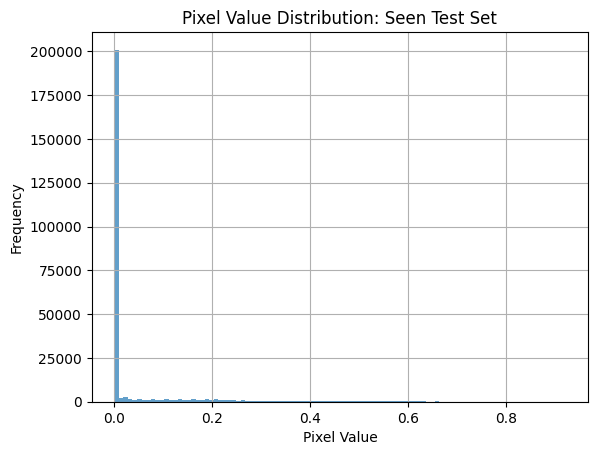

In [12]:
import numpy as np

def inspect_pixel_stats(X, name="dataset"):
    print(f"Stats for {name}:")
    print(f"  Min: {X.min()}")
    print(f"  Max: {X.max()}")
    print(f"  Mean: {X.mean():.4f}")
    print(f"  Std: {X.std():.4f}")
    print(f"  Shape: {X.shape}")
    print()

# Example usage
inspect_pixel_stats(test_data[110][0][:], "Seen Test Set")
# inspect_pixel_stats(X_test_unseen, "Unseen Test Set")

import matplotlib.pyplot as plt

def plot_pixel_histogram(X, name="dataset"):
    plt.hist(X.flatten(), bins=100, alpha=0.7)
    plt.title(f"Pixel Value Distribution: {name}")
    plt.xlabel("Pixel Value")
    plt.ylabel("Frequency")
    plt.grid(True)
    plt.show()

plot_pixel_histogram(test_data[110][0][1], "Seen Test Set")


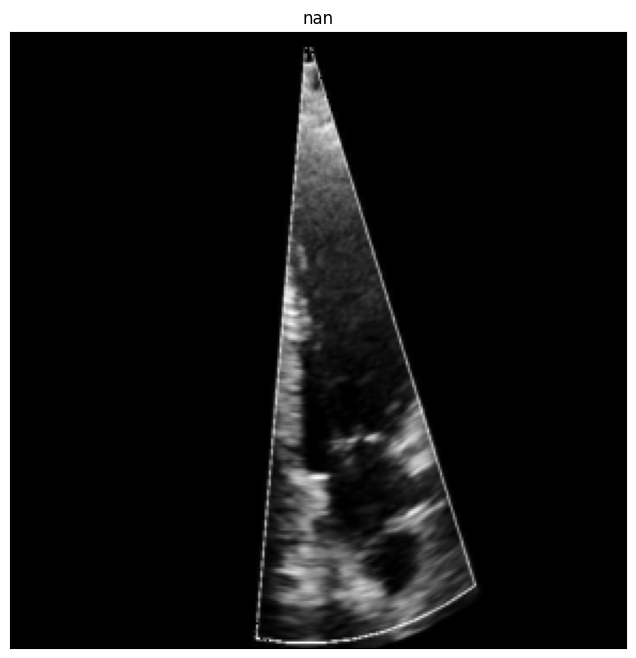

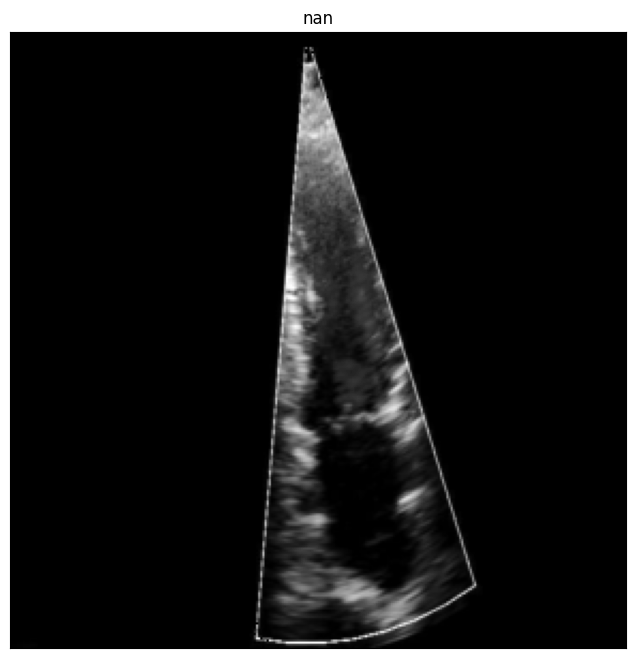

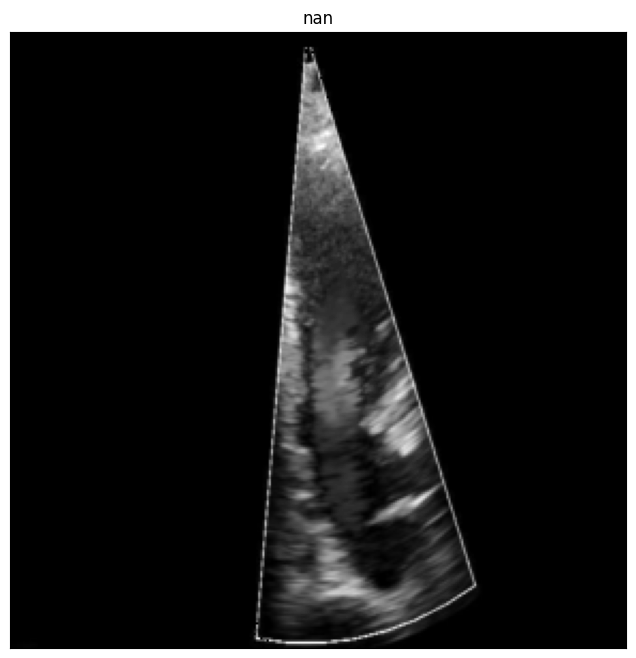

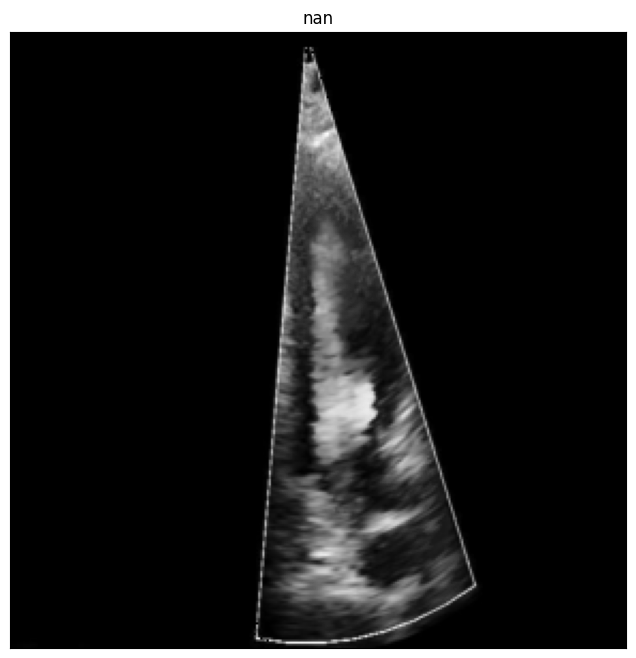

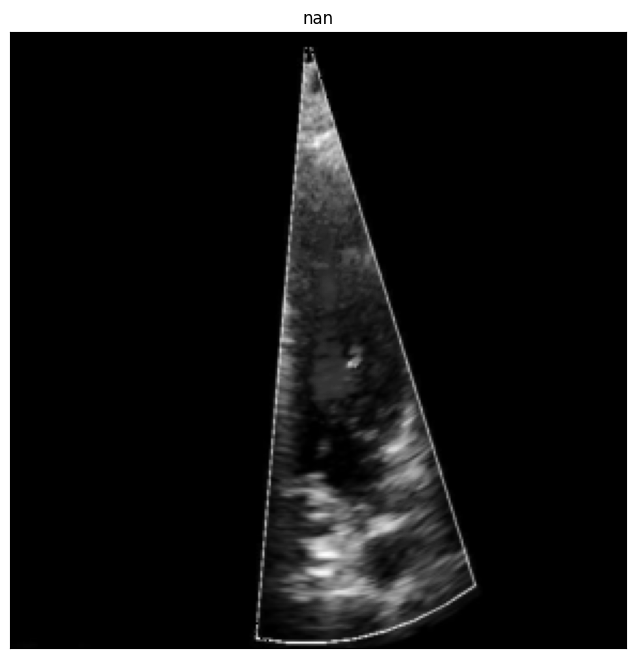

In [13]:
dt = test_data[110][0][:]
lb = test_data[10][1]
num  = len(dt)
for i in range(num):
    visualization(dt[i,-1], lb)
    
# dt1 = train_data[60][0][:]
# lb1 = train_data[60][1]
# for i in range(num):
#     visualization(dt1[i,-1], lb1)

### Create data loaders for the train and validation sets



In [29]:
# train_loader = DataLoader(train_data, batch_size=32, drop_last=True, shuffle=True, pin_memory=True, num_workers= 8)
# #, pin_memory=True, num_workers= 8, persistent_workers=True)

# val_loader = DataLoader(val_data, batch_size=32, drop_last=False, shuffle=False, pin_memory=True, num_workers= 8)
#pin_memory=True, num_workers= 8, persistent_workers=True)

test_loader = DataLoader(test_data, batch_size=32, drop_last=False, shuffle=False, pin_memory=True, num_workers= 8)
#pin_memory=True, num_workers= 8, persistent_workers=True)


In [30]:
for img, lbl in test_loader:
    print(img.shape)

torch.Size([32, 5, 3, 288, 288])
torch.Size([32, 5, 3, 288, 288])
torch.Size([32, 5, 3, 288, 288])
torch.Size([32, 5, 3, 288, 288])
torch.Size([32, 5, 3, 288, 288])
torch.Size([32, 5, 3, 288, 288])
torch.Size([32, 5, 3, 288, 288])
torch.Size([32, 5, 3, 288, 288])
torch.Size([32, 5, 3, 288, 288])
torch.Size([32, 5, 3, 288, 288])
torch.Size([32, 5, 3, 288, 288])
torch.Size([32, 5, 3, 288, 288])
torch.Size([32, 5, 3, 288, 288])
torch.Size([32, 5, 3, 288, 288])
torch.Size([32, 5, 3, 288, 288])
torch.Size([32, 5, 3, 288, 288])
torch.Size([32, 5, 3, 288, 288])
torch.Size([32, 5, 3, 288, 288])
torch.Size([32, 5, 3, 288, 288])
torch.Size([32, 5, 3, 288, 288])
torch.Size([32, 5, 3, 288, 288])
torch.Size([32, 5, 3, 288, 288])
torch.Size([32, 5, 3, 288, 288])
torch.Size([32, 5, 3, 288, 288])
torch.Size([32, 5, 3, 288, 288])
torch.Size([32, 5, 3, 288, 288])
torch.Size([32, 5, 3, 288, 288])
torch.Size([32, 5, 3, 288, 288])
torch.Size([32, 5, 3, 288, 288])
torch.Size([32, 5, 3, 288, 288])
torch.Size

Exception in thread Thread-17 (_pin_memory_loop):
Traceback (most recent call last):
  File "/usr/lib/python3.11/threading.py", line 1045, in _bootstrap_inner
    self.run()
  File "/home/shokoo/.local/lib/python3.11/site-packages/ipykernel/ipkernel.py", line 766, in run_closure
    _threading_Thread_run(self)
  File "/usr/lib/python3.11/threading.py", line 982, in run
    self._target(*self._args, **self._kwargs)
  File "/home/shokoo/.local/lib/python3.11/site-packages/torch/utils/data/_utils/pin_memory.py", line 54, in _pin_memory_loop
    do_one_step()
  File "/home/shokoo/.local/lib/python3.11/site-packages/torch/utils/data/_utils/pin_memory.py", line 31, in do_one_step
    r = in_queue.get(timeout=MP_STATUS_CHECK_INTERVAL)
        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/queues.py", line 122, in get
    return _ForkingPickler.loads(res)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/shokoo/.local/lib/python3.11/site-packages/t

torch.Size([32, 5, 3, 288, 288])
torch.Size([32, 5, 3, 288, 288])
torch.Size([32, 5, 3, 288, 288])
torch.Size([32, 5, 3, 288, 288])
torch.Size([32, 5, 3, 288, 288])
torch.Size([32, 5, 3, 288, 288])
torch.Size([32, 5, 3, 288, 288])
torch.Size([32, 5, 3, 288, 288])


KeyboardInterrupt: 

### Define the neural network model architecture

In [12]:
# the model that gave me temporal and spatial differently

class ResidualCombination(nn.Module):
    def __init__(self, feature_dim):
        super(ResidualCombination, self).__init__()
        self.fc1 = nn.Linear(feature_dim, feature_dim // 2)
        # self.bn1 = nn.BatchNorm1d(feature_dim // 2)  # Add BatchNorm
        self.fc2 = nn.Linear(feature_dim // 2, feature_dim)
        # self.bn2 = nn.BatchNorm1d(feature_dim)  # Add BatchNorm
        
    def forward(self, x):
        # Reshape for BatchNorm
        batch_size, seq_len, feat_dim = x.shape
        x = x.view(-1, feat_dim)
        
        x = self.fc1(x)
        # x = self.bn1(x)
        x = torch.relu(x)
        
        x = self.fc2(x)
        # x = self.bn2(x)
        alpha = torch.sigmoid(x)
        
        # Restore original shape
        alpha = alpha.view(batch_size, seq_len, feat_dim)
        return alpha

class ConvWeighting(nn.Module):
    def __init__(self, in_channels, cnn_output_size, num_classes):
        super(ConvWeighting, self).__init__()
        self.hidden_size = 1408
        self.num_heads = 2
        self.num_classes = num_classes
        self.cnn_output_size = cnn_output_size

        self.feature = torchvision.models.efficientnet_b2(weights='DEFAULT').features
        # self.mhsa = nn.MultiheadAttention(self.cnn_output_size, self.num_heads, batch_first=True)
        self.dilated_conv1d = nn.Conv1d(self.cnn_output_size, self.hidden_size, kernel_size = 3, dilation = 2, padding=2)
        # self.temporal_bn = nn.BatchNorm1d(self.hidden_size)
        self.classifier_layer = nn.Sequential(nn.Dropout(0.2), nn.Linear(self.hidden_size, num_classes))

        # Add the ResidualCombination module
        self.residual_combination = ResidualCombination(feature_dim=1408)

    def forward(self, x):
        batch_size, seq_len, C, H, W = x.size()

        c_in = x.view(batch_size * seq_len, C, H, W)
        f_out = self.feature(c_in)
        f_out = torch.mean(f_out, dim=[2, 3])  # Spatial averaging
        spatial = f_out.view(batch_size, seq_len, -1)  # Latent spatial feature vector # Shape: (8, 6, 1408)


        c_in = spatial.permute(0, 2, 1) #Time goes to the third dimension
        temporal = self.dilated_conv1d(c_in) # Shape: (8, 1408, 6)
        # temporal, _ = self.mhsa(spatial, spatial, spatial)
        # temporal = self.temporal_bn(temporal) # Normalize the temporal
        temporal = temporal.permute(0, 2, 1)


        # Concatenate along the time dimension
        cat_feature = torch.cat([spatial, temporal], dim=1)  # Shape: (8, 12, 1408)
        # Use the residual combination module (operate on the last dimension)
        residual = self.residual_combination(cat_feature)  # Shape: (8, 12, 1408)
        output = residual * cat_feature

    
        # Apply the classifier to the mean of the sequence dimension
        output = self.classifier_layer(output.mean(dim=1))  # Shape: (8, num_classes)
        
        return output, torch.softmax(output, dim=1), residual, temporal, spatial

model = ConvWeighting(3, 1408, 11)

In [31]:
# New model

class ChannelAttention(nn.Module):
    def __init__(self, in_channels, reduction_ratio=16):
        super(ChannelAttention, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool1d(1)
        self.max_pool = nn.AdaptiveMaxPool1d(1)
        
        # Shared MLP for channel attention
        self.mlp = nn.Sequential(
            nn.Linear(in_channels, in_channels // reduction_ratio),
            nn.ReLU(),
            nn.Linear(in_channels // reduction_ratio, in_channels)
        )
        
        # Separate normalization for temporal features
        self.temporal_bn = nn.BatchNorm1d(in_channels)
        
    def forward(self, x, is_temporal=False):
        # x shape: (batch_size, channels, seq_len)
        b, c, t = x.size()
        
        # Average pooling
        avg_pool = self.avg_pool(x).view(b, c)
        avg_out = self.mlp(avg_pool)
        
        # Max pooling
        max_pool = self.max_pool(x).view(b, c)
        max_out = self.mlp(max_pool)
        
        # Combine attention scores
        channel_att = torch.sigmoid(avg_out + max_out).view(b, c, 1)
        
        if is_temporal:
            # Normalize temporal features channel-wise
            x = self.temporal_bn(x)
            
        return channel_att

class NewConvWeighting(nn.Module):
    def __init__(self, in_channels, cnn_output_size, num_classes):
        super(NewConvWeighting, self).__init__()
        self.hidden_size = 1408
        self.num_classes = num_classes
        self.cnn_output_size = cnn_output_size

        # Spatial feature extractor
        self.feature = torchvision.models.efficientnet_b2(weights='DEFAULT').features
        
        # Temporal feature extractor
        self.dilated_conv1d = nn.Conv1d(self.cnn_output_size, self.hidden_size, 
                                       kernel_size=3, dilation=2, padding=2)
        
        # Channel attention modules
        self.spatial_attention = ChannelAttention(self.hidden_size)
        self.temporal_attention = ChannelAttention(self.hidden_size)
        
        # Classifier
        self.classifier_layer = nn.Sequential(
            nn.Dropout(0.2),
            nn.Linear(self.hidden_size, num_classes)
        )

    def forward(self, x):
        batch_size, seq_len, C, H, W = x.size()
        
        # Spatial feature extraction
        c_in = x.view(batch_size * seq_len, C, H, W)
        f_out = self.feature(c_in)
        f_out = torch.mean(f_out, dim=[2, 3])
        spatial = f_out.view(batch_size, seq_len, -1)
        
        # Reshape for channel attention
        spatial = spatial.permute(0, 2, 1)  # (batch_size, channels, seq_len)
        
        # Temporal feature extraction
        temporal = self.dilated_conv1d(spatial)  # Already in (batch_size, channels, seq_len) format
        
        # Apply channel-wise attention
        spatial_weights = self.spatial_attention(spatial, is_temporal=False)
        temporal_weights = self.temporal_attention(temporal, is_temporal=True)
        
        # Apply attention weights
        weighted_spatial = spatial_weights * spatial
        weighted_temporal = temporal_weights * temporal
        
        # Combine features
        combined = (weighted_spatial + weighted_temporal) / 2
        
        # Global temporal pooling and classification
        output = combined.mean(dim=2)  # Average over sequence length
        output = self.classifier_layer(output)
        
        # Return spatial weights and temporal weights in original channel dimension
        return (
            output, 
            torch.softmax(output, dim=1),
            spatial_weights.squeeze(-1),  # Remove sequence dimension
            temporal_weights.squeeze(-1),  # Remove sequence dimension
            spatial.permute(0, 2, 1)  # Return to original format
        )
model = NewConvWeighting(3, 1408, 11)

### simple model test

In [37]:
# input1 = torch.rand(8, 10, 3, 299, 299)
input2 = torch.rand(8, 6, 3, 299, 299)
model.eval()
# print(model(input1))
output, _, _, temporal, spatial = model(input2)
output.shape

torch.Size([8, 11])

### Define loss and optimizer

In [13]:
torch.cuda.is_available()
# !export CUDA_VISIBLE_DEVICES=0
# !nvidia-smi
# torch.cuda.empty_cache()

True

#### Noramal loss

In [32]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
# device = torch.device('cuda:0')
model.to(device)
# model.lstm.flatten_parameters() 
if torch.cuda.device_count() > 1:
  print("Let's use", torch.cuda.device_count(), "GPUs!")
  model = nn.DataParallel(model)


# model.lstm.flatten_parameters() 
criterion = torch.nn.CrossEntropyLoss()
# optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
# optimizer = torch.optim.SGD(filter(lambda p: p.requires_grad, model.parameters()), lr=0.1, momentum=0.9)

print(device)

cuda


### Train the model

In [84]:
def evaluate(model, loader, device, criterion, mode='validation'):
  model.eval()
  total_correct = 0
  total_loss = 0
  # BATCH_SIZE = 64
  total = 0
  for i, (images, labels) in enumerate(loader):
    images = images.to(device)
    labels = labels.to(device)
    labels = labels.squeeze(1)
    with torch.no_grad():
      outputs, _, _, _, _ = model(images)
      loss = criterion(outputs, labels)
      total_loss += loss.item() * images.size(0)
      total += images.size(0) #TODO: if number of sampels increase more than one it SHOULD increase as well
      _, predictions = outputs.max(1)
      total_correct += (labels == predictions).sum()
      # print(predictions, labels, labels == predictions, total_correct, total, images.size(0))

  # print(total_correct, total, accuracy)
  loss = total_loss / total
  accuracy = total_correct / total
  print(f'{mode} epoch {epoch}: Loss({loss:6.4f}),  Accuracy ({accuracy:6.4f}))')
  return accuracy, loss

In [85]:
# model = model.to(device)
epochs = 5
# BATCH_SIZE = 64
accs = []
losses = []
for epoch in range(epochs):
  model.train()
  total = 0
  running_loss = 0.
  running_corrects = 0
  val_loss = 0.0
  # epochs_no_improve = 0
  best_val_loss = float('inf')
  for i, (images, labels) in enumerate(train_loader):
    images = images.to(device)
    labels = labels.to(device)
    optimizer.zero_grad()
    outputs, _, _, _, _ = model(images)
    # print(images)
    # print(outputs)
    labels = labels.squeeze(1)
    loss = criterion(outputs, labels)
    loss.backward()
    torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1)
    optimizer.step()

    total += images.size(0)
    _, predictions = outputs.max(1)
    # print(predictions, labels)
    running_loss += loss.item() * images.size(0)
    running_corrects += (predictions == labels).sum()

  epoch_loss = running_loss / total
  epoch_acc = running_corrects / total
  accs.append(epoch_acc)
  losses.append(epoch_loss)
  # loss = total_loss / total
  print(f'Train epoch {epoch}: Loss({epoch_loss:6.4f}, Accuracy ({epoch_acc:6.5f}) )')
  val_acc, val_loss = evaluate(model, val_loader, device, criterion, mode='valid')
  accs.append(val_acc)
  losses.append(val_loss)

  print('---')

  if(val_loss < best_val_loss):
    best_val_loss = val_loss
    epochs_no_improve = 0
    torch.save(model.state_dict(), (f'{epoch+12}-newModel_weightedChannelWise.pth'))
  else:
    epochs_no_improve += 1

  if epochs_no_improve > 3:
    print('no further improvement')
    break


Train epoch 0: Loss(0.4451, Accuracy (0.85065) )
valid epoch 0: Loss(0.8084),  Accuracy (0.8278))
---
Train epoch 1: Loss(0.1685, Accuracy (0.94567) )
valid epoch 1: Loss(0.9191),  Accuracy (0.8245))
---
Train epoch 2: Loss(0.1117, Accuracy (0.96484) )
valid epoch 2: Loss(0.8504),  Accuracy (0.8067))
---
Train epoch 3: Loss(0.0908, Accuracy (0.97274) )
valid epoch 3: Loss(0.8659),  Accuracy (0.8227))
---
Train epoch 4: Loss(0.0706, Accuracy (0.97839) )
valid epoch 4: Loss(0.9400),  Accuracy (0.8224))
---


### Load pre-trained model 

In [33]:
# device = torch.device('cuda:0')
# Load your model and ensure all its parameters are on the default device
model = NewConvWeighting(3,1408, 11)
state_dict = torch.load('/home/shokoo/EchoView/video_class/multiframe/14-newModel_weightedChannelWise.pth', map_location='cpu')
new_state_dict = {k.replace('module.', ''): v for k, v in state_dict.items()}
model.load_state_dict(new_state_dict)
model.to(device)
# model = nn.DataParallel(model, device_ids=[0, 1])
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


# model = CNNLSTM(3, 1000, 11)
# model.load_state_dict(torch.load('customizedEN6-acc86-loss0.5.pth'))
# model = nn.DataParallel(model, device_ids=[0,1])
# model.eval()


# model = CNNLSTM(3, 1000, 11)  # adjust according to your model definition
# state_dict = torch.load('customizedEN6-acc86-loss0.5.pth', map_location='cpu')
# # Create a new state dictionary with the module prefix removed
# new_state_dict = {k[len("module."):]: v for k, v in state_dict.items()}
# model.load_state_dict(new_state_dict)
# model.eval()

### Test without ensembling 

In [34]:
def evaluate_test(model, loader, device, mode='Test'):
    model.eval()
    indices = []
    predicted_labels = []
    true_labels = []
    confidences = []
    alphas = []
    temporals = []
    spatials = []
    total_correct = 0
    total_loss = 0
    # BATCH_SIZE = 64
    total = 0
    for enum, (images, labels) in enumerate(loader):
        images = images.to(device)
        labels = labels.to(device)
        # labels = labels.squeeze(1)
        with torch.no_grad():
            outputs, confidence, alpha, temporal, spatial = model(images)
            # loss = criterion(outputs, labels)
            # total_loss += loss.item() * images.size(0)
            # total += images.size(0) 
            _, predictions = confidence.max(1)
            # total_correct += (labels == predictions).sum()
            batch_start = enum * loader.batch_size
            batch_indices = list(range(batch_start, batch_start + images.size(0)))
            # alphas.extend(alpha.cpu().numpy())
            # temporals.extend(temporal.cpu().numpy())
            # spatials.extend(spatial.cpu().numpy())
            confidences.extend(confidence.cpu().numpy())
            indices.extend(batch_indices)
            predicted_labels.extend(predictions.cpu().numpy())
            # true_labels.extend(labels.cpu().numpy())

        # print(total_correct, total, accuracy)
    # loss = total_loss / total
    # accuracy = total_correct / total
    # print(f'{mode} Loss({loss:6.4f}),  Accuracy ({accuracy:6.4f}))')
    test_dict = { 'indicies': indices, 'predicted': predicted_labels, 'confidence_score': confidences}
    return test_dict

### evaluate test

In [38]:
test_dict = evaluate_test(model, loader= test_loader, device = device)

In [39]:
test_df = pd.DataFrame(test_dict)
test = pd.concat([test_df, info_test], axis = 1)
test

,indicies,predicted,confidence_score,path,label,start,end
0,0,3,"[0.0058017457, 0.00034279382, 0.017220892, 0.9...",cardiac_stress_study/BpjtCYA-RwOTIWaocpT7mg/86/0,NaN,1,14
1,1,8,"[3.5523555e-09, 8.6623694e-11, 2.4549945e-10, ...",cardiac_stress_study/BpjtCYA-RwOTIWaocpT7mg/90/0,NaN,3,27
2,2,4,"[1.1871365e-07, 7.473204e-09, 6.324072e-07, 5....",cardiac_stress_study/BpjtCYA-RwOTIWaocpT7mg/9/0,NaN,6,17
3,3,1,"[0.28387946, 0.46738422, 0.101792134, 0.023472...",cardiac_stress_study/BpjtCYA-RwOTIWaocpT7mg/55/0,NaN,4,36
4,4,6,"[3.278998e-08, 1.3957745e-13, 2.6982487e-12, 1...",cardiac_stress_study/BpjtCYA-RwOTIWaocpT7mg/57/0,NaN,2,12
...,...,...,...,...,...,...,...
7605,7605,8,"[1.1998738e-12, 2.5630195e-13, 1.0545354e-12, ...",US guided biopsy/6Xmbq5veQTuCeyf5jBTKww/2/0,NaN,18,39
7606,7606,10,"[0.15425688, 0.0014625432, 6.2785875e-05, 3.88...",US guided biopsy/6Xmbq5veQTuCeyf5jBTKww/7/0,NaN,35,104
7607,7607,0,"[0.75680786, 0.039800536, 0.0020988793, 0.0025...",US guided biopsy/6Xmbq5veQTuCeyf5jBTKww/4/0,NaN,4,82
7608,7608,10,"[0.00024733026, 0.0022487142, 0.0031063862, 0....",US guided biopsy/6Xmbq5veQTuCeyf5jBTKww/5/0,NaN,1,151


In [40]:
test.to_csv('predicted_View_labels(amy)2.csv', index=False)

In [89]:
test_df = pd.DataFrame(test_dict)

In [67]:
# mapping the predicted df to the true df of test set
test_df = pd.DataFrame(test_dict)
test = pd.concat([test_df, info_test], axis = 1)
test
def get_mode(series):
    return series.mode()[0] if not series.mode().empty else None

def get_mean(series):
    return series.mean()

res = test.groupby(['path', 'true_labels']).agg({ 'confidence_score': get_mean, 'alpha':get_mean, 'spatial':get_mean, 'temporal':get_mean} ).reset_index() 
res['predicted'] = res['confidence_score'].apply(lambda x : x.argmax())
res
def calculate_accuracy(true_labels, predicted_labels):
    correct = sum(1 for true, pred in zip(true_labels, predicted_labels) if true == pred)
    print(correct)
    total = len(true_labels)
    print(total, total - correct)
    accuracy = correct / total
    return accuracy

true_labels, pred_labels = res['true_labels'], res['predicted']
print(calculate_accuracy(true_labels, pred_labels))
res['same_video'] = res['path'].astype(str).apply(lambda x: '/'.join(x.split('/')[:-1]))
res2 = res.groupby(['same_video', 'true_labels']).agg({'confidence_score': get_mean, 'alpha':get_mean, 'spatial':get_mean, 'temporal':get_mean}).reset_index() 
res2['predicted'] = res2['confidence_score'].apply(lambda x: x.argmax())
res2
def calculate_accuracy(true_labels, predicted_labels):
    correct = sum(1 for true, pred in zip(true_labels, predicted_labels) if true == pred)
    total = len(true_labels)
    accuracy = correct / total
    return accuracy

true_labels, pred_labels = res2['true_labels'], res2['predicted']
calculate_accuracy(true_labels, pred_labels)

467
503 36
0.9284294234592445


0.9352226720647774

In [79]:
pd.DataFrame([true_labels, pred_labels]).to_csv('results_Conv1dDilated_with_NormalizedWeightedFeatures.csv', index=False)

In [90]:
test_df.columns

Index(['indices', 'predicted', 'true_labels', 'confidence_score', 'alpha',
       'temporal', 'spatial'],
      dtype='object')

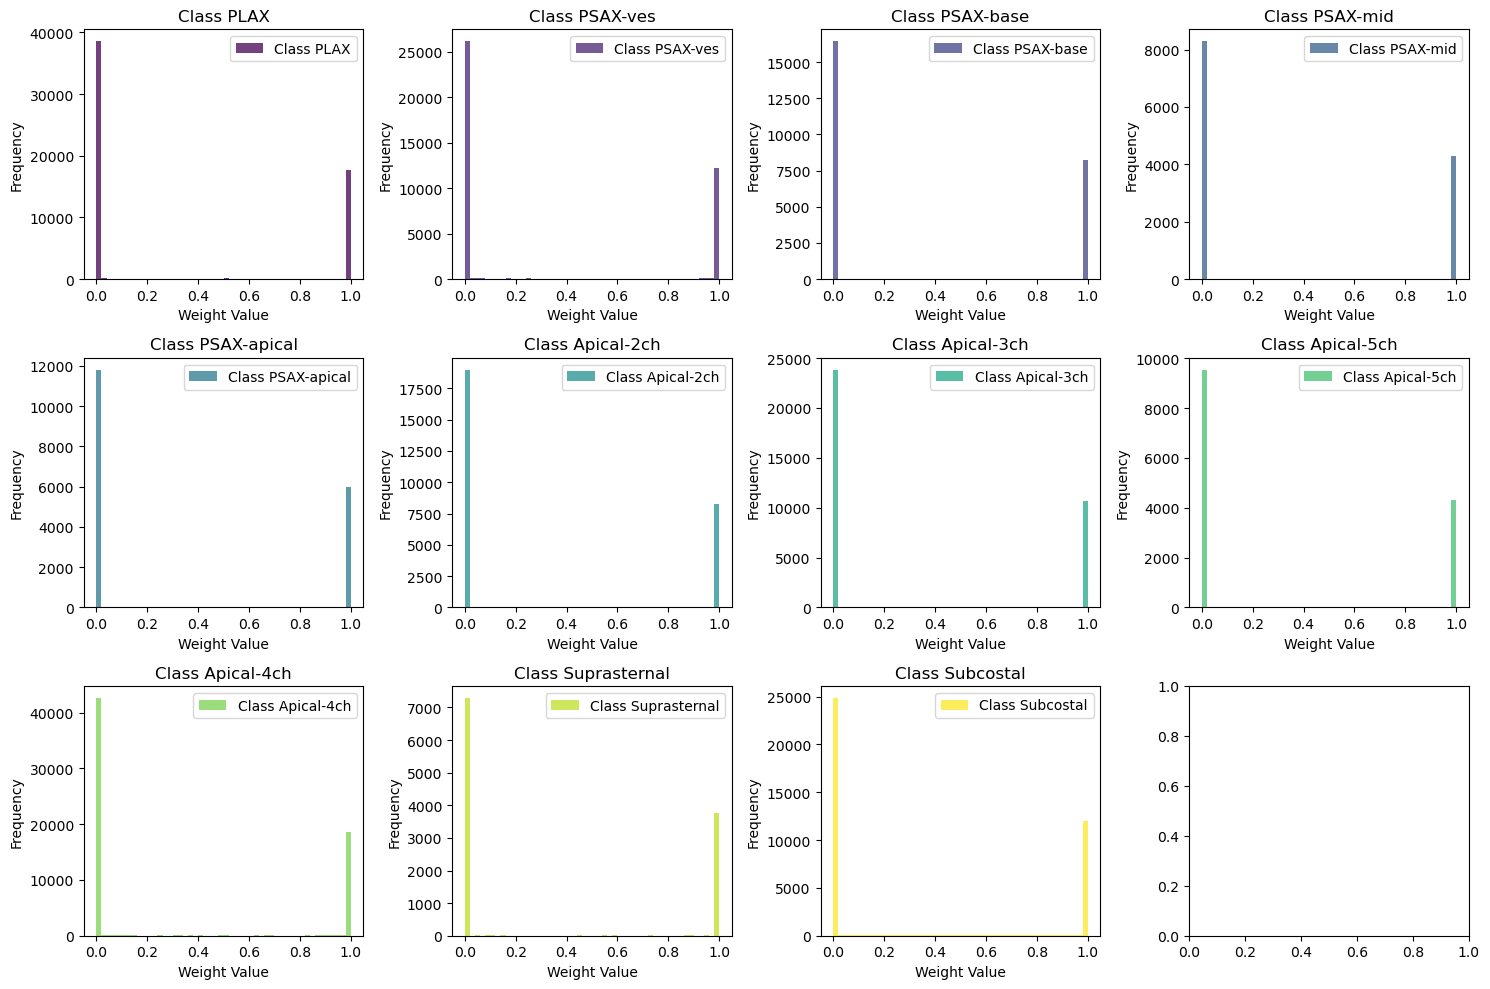

In [100]:
# np.mean(test_dict['alpha'])
# np.array([alpha[6:] for alpha in test_dict['alpha']]).mean(axis=0).mean()

import matplotlib.pyplot as plt

# # Assuming alpha has shape (batch_size, seq_len, feature_dim)
# alpha_values = np.concatenate([alpha.flatten() for alpha in test_df['temporal']])
# plt.hist(alpha_values, bins=50, alpha=0.75, color='b')
# plt.xlabel('Weight Value')
# plt.ylabel('Frequency')
# plt.title('Distribution of Weighted Values')
# # plt.savefig('weights.svg')
# plt.show()

valid_labels = {0:'PLAX', 1:'PSAX-ves', 2:'PSAX-base', 3:'PSAX-mid', 4: 'PSAX-apical',
                              5:'Apical-2ch', 6:'Apical-3ch',
                              7:'Apical-5ch', 8:'Apical-4ch', 9:'Suprasternal', 10:'Subcostal' 
                }

class_alpha_means = []
for cls in range(11):
    class_alpha = res2[res2['predicted'] == cls].temporal
    # .apply(lambda x: x[:6])
    alpha_mean = np.stack(class_alpha.values).mean(axis=0)
    class_alpha_means.append(class_alpha)


# Define colors for the classes
colors = plt.cm.viridis(np.linspace(0, 1, 11))  # Using a colormap for distinct colors

# Create a figure with subplots for each class
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(15, 10))  # Adjust the size and number of subplots as needed
axes = axes.flatten()

# Plot alpha values for each class in a separate subplot
for cls in range(11):
    alpha_values = np.concatenate([a.flatten() for a in class_alpha_means[cls]])
    axes[cls].hist(alpha_values, bins=50, alpha=0.75, color=colors[cls], label=f'Class {valid_labels[cls]}')
    axes[cls].set_xlabel('Weight Value')
    axes[cls].set_ylabel('Frequency')
    axes[cls].set_title(f'Class {valid_labels[cls]}')
    axes[cls].legend()

# Adjust layout to prevent overlap
plt.tight_layout()
# plt.savefig('temporal_feature_range.svg')
plt.show()


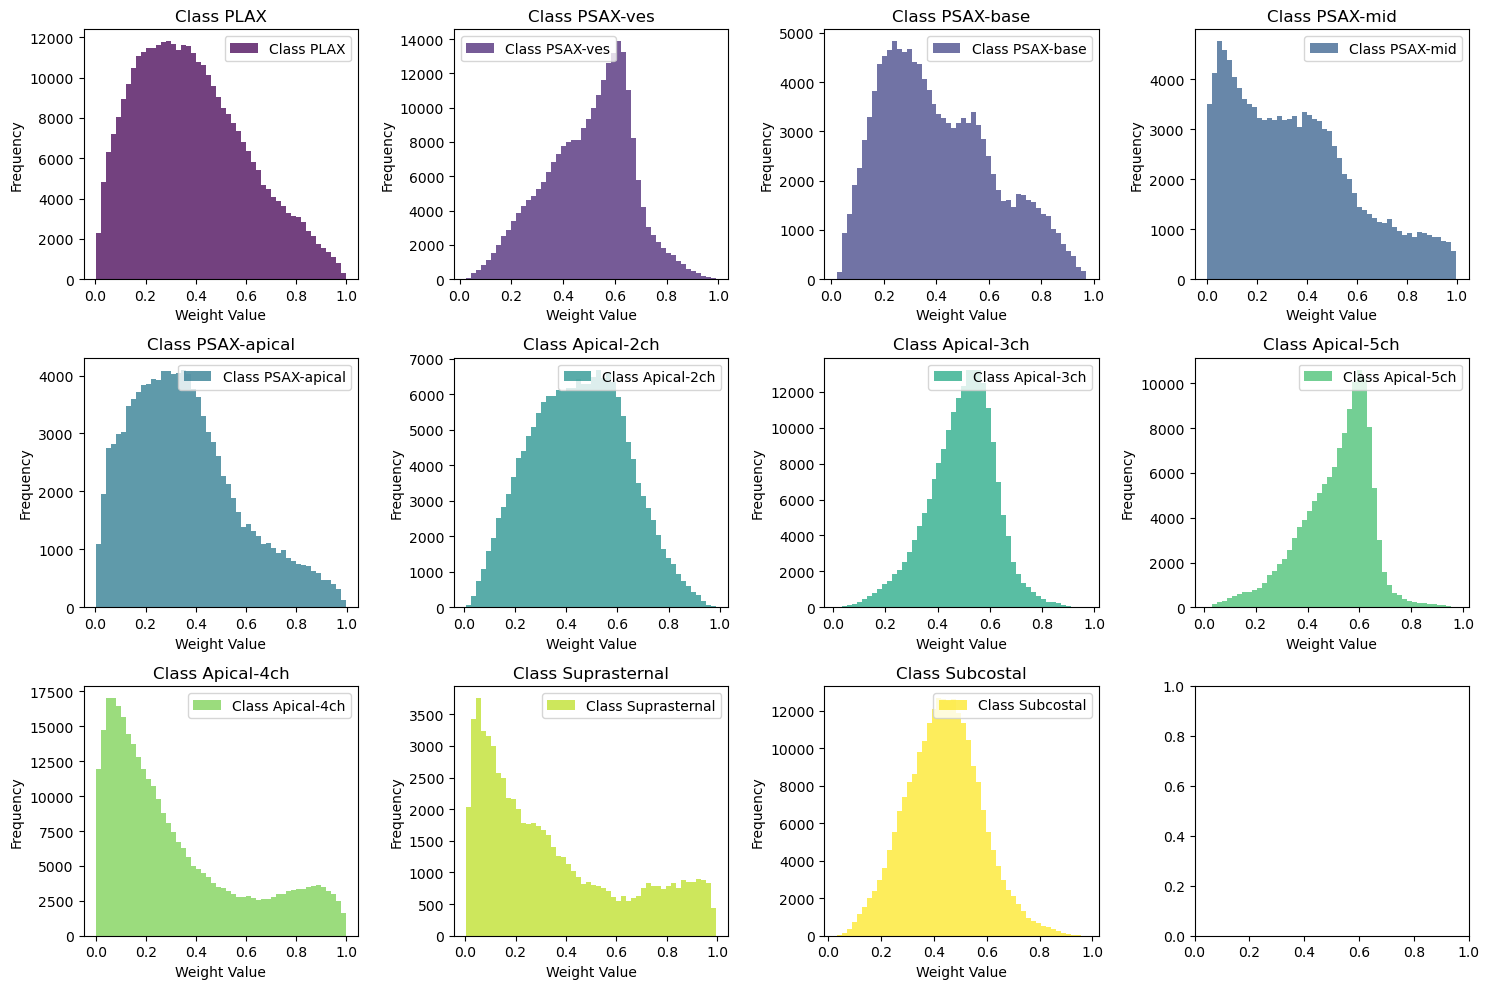

In [76]:
# np.mean(test_dict['alpha'])
# np.array([alpha[6:] for alpha in test_dict['alpha']]).mean(axis=0).mean()

import matplotlib.pyplot as plt

# Assuming alpha has shape (batch_size, seq_len, feature_dim)
# alpha_values = np.concatenate([alpha.flatten() for alpha in test_df['alpha']])
# plt.hist(alpha_values, bins=50, alpha=0.75, color='b')
# plt.xlabel('Weight Value')
# plt.ylabel('Frequency')
# plt.title('Distribution of Weighted Values')
# plt.savefig('weights.svg')
# plt.show()

valid_labels = {0:'PLAX', 1:'PSAX-ves', 2:'PSAX-base', 3:'PSAX-mid', 4: 'PSAX-apical',
                              5:'Apical-2ch', 6:'Apical-3ch',
                              7:'Apical-5ch', 8:'Apical-4ch', 9:'Suprasternal', 10:'Subcostal' 
                }

class_alpha_means = []
for cls in range(11):
    class_alpha = res2[res2['predicted'] == cls].alpha.apply(lambda x: x[6:])
    alpha_mean = np.stack(class_alpha.values).mean(axis=0)
    class_alpha_means.append(class_alpha)


# Define colors for the classes
colors = plt.cm.viridis(np.linspace(0, 1, 11))  # Using a colormap for distinct colors

# Create a figure with subplots for each class
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(15, 10))  # Adjust the size and number of subplots as needed
axes = axes.flatten()

# Plot alpha values for each class in a separate subplot
for cls in range(11):
    alpha_values = np.concatenate([a.flatten() for a in class_alpha_means[cls]])
    axes[cls].hist(alpha_values, bins=50, alpha=0.75, color=colors[cls], label=f'Class {valid_labels[cls]}')
    axes[cls].set_xlabel('Weight Value')
    axes[cls].set_ylabel('Frequency')
    axes[cls].set_title(f'Class {valid_labels[cls]}')
    axes[cls].legend()

# Adjust layout to prevent overlap
plt.tight_layout()
# plt.savefig('temporal_feature_range.svg')
plt.show()


In [111]:
res2['alpha'].mean().mean()

0.42238346

In [74]:
np.array([alpha[:6] for alpha in res2['alpha']]).mean(axis=0).mean()

0.6145126

In [75]:
np.array([alpha[6:] for alpha in res2['alpha']]).mean(axis=0).mean()

0.41571695

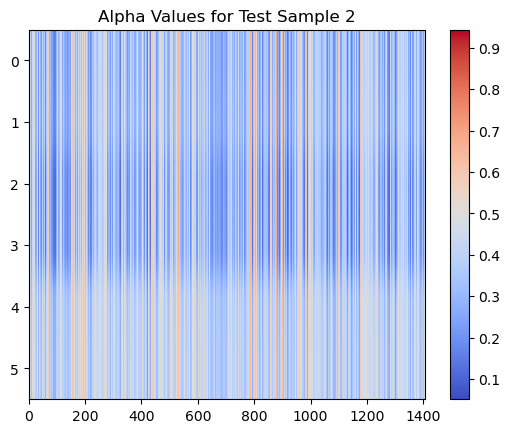

0.6207046


In [73]:
sample_alpha = res2['alpha'][7]
# Visualize alpha values for this sample
plt.imshow(sample_alpha[6:], cmap='coolwarm', aspect='auto')
plt.colorbar()
plt.title(f'Alpha Values for Test Sample {2}')
plt.show()

print(sample_alpha[:6].mean())

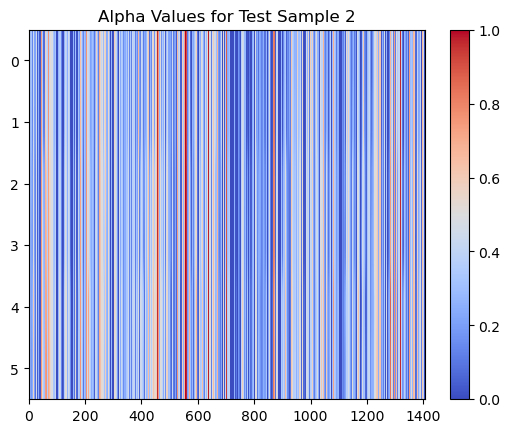

0.30890414


In [42]:
sample_alpha = res2['alpha'][2]
# Visualize alpha values for this sample
plt.imshow(sample_alpha[6:], cmap='coolwarm', aspect='auto')
plt.colorbar()
plt.title(f'Alpha Values for Test Sample {2}')
plt.show()

print(sample_alpha[6:].mean())

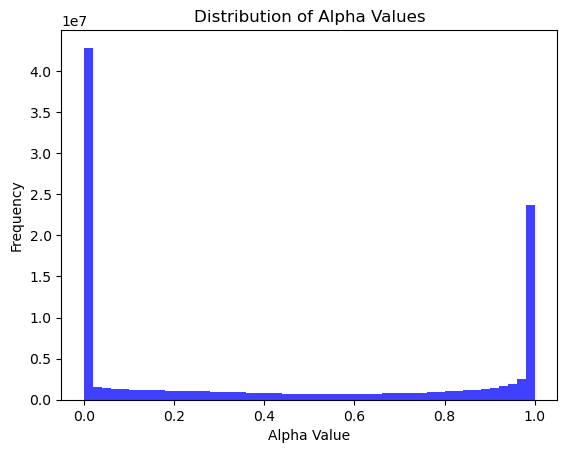

In [43]:
import matplotlib.pyplot as plt

# Assuming alpha has shape (batch_size, seq_len, feature_dim)
alpha_values = np.concatenate([alpha.flatten() for alpha in test_dict['alpha']])
plt.hist(alpha_values, bins=50, alpha=0.75, color='b')
plt.xlabel('Alpha Value')
plt.ylabel('Frequency')
plt.title('Distribution of Alpha Values')
plt.show()


In [72]:
class_alpha_means[0]

0      [[0.5337967, 0.9031165, 0.5944402, 0.71349764,...
1      [[0.6448598, 0.86452544, 0.6121198, 0.6986799,...
5      [[0.6603515, 0.9285457, 0.6674911, 0.7913507, ...
16     [[0.30058724, 0.8219775, 0.5312616, 0.5714787,...
17     [[0.5132464, 0.87591326, 0.6189132, 0.6968677,...
21     [[0.4600669, 0.8908343, 0.66972023, 0.7141053,...
23     [[0.33074513, 0.8058733, 0.62160605, 0.5604302...
29     [[0.34035802, 0.85556227, 0.6219304, 0.5867076...
37     [[0.23766616, 0.78328323, 0.52459514, 0.509459...
40     [[0.40458137, 0.8437555, 0.5849128, 0.59219396...
61     [[0.24775761, 0.7810239, 0.5963034, 0.49577302...
62     [[0.3111109, 0.80640846, 0.53404665, 0.5903488...
63     [[0.22096676, 0.8827332, 0.6043956, 0.5682271,...
65     [[0.20857462, 0.83420944, 0.45939323, 0.573405...
72     [[0.22008975, 0.8301216, 0.48991188, 0.5693362...
87     [[0.26890168, 0.9229791, 0.6978806, 0.67435116...
94     [[0.30674517, 0.9121866, 0.7009569, 0.6694664,...
107    [[0.2995815, 0.83970773,

In [83]:
res2[res2['predicted'] == 1].alpha

2    [[0.8915528, 0.9744915, 0.7511164, 0.9053525, ...
3    [[0.80700743, 0.90845275, 0.524199, 0.7859746,...
4    [[0.8357127, 0.942093, 0.4776795, 0.83649945, ...
Name: alpha, dtype: object

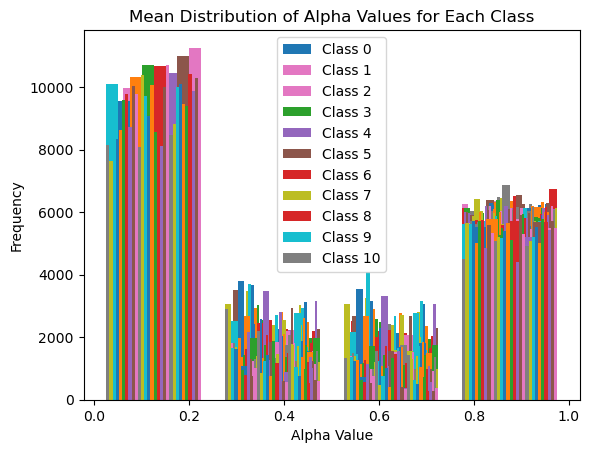

In [112]:
class_alpha_means = []
for cls in range(11):
    class_alpha = res2[res2['predicted'] == cls].alpha
    alpha_mean = np.stack(class_alpha.values).mean(axis=0)
    class_alpha_means.append(class_alpha)

for cls, alpha_mean in enumerate(class_alpha_means):
    plt.hist(alpha_mean, bins=4, alpha=1, label=f'Class {cls}')

plt.xlabel('Alpha Value')
plt.ylabel('Frequency')
plt.title('Mean Distribution of Alpha Values for Each Class')
plt.legend()
plt.show()

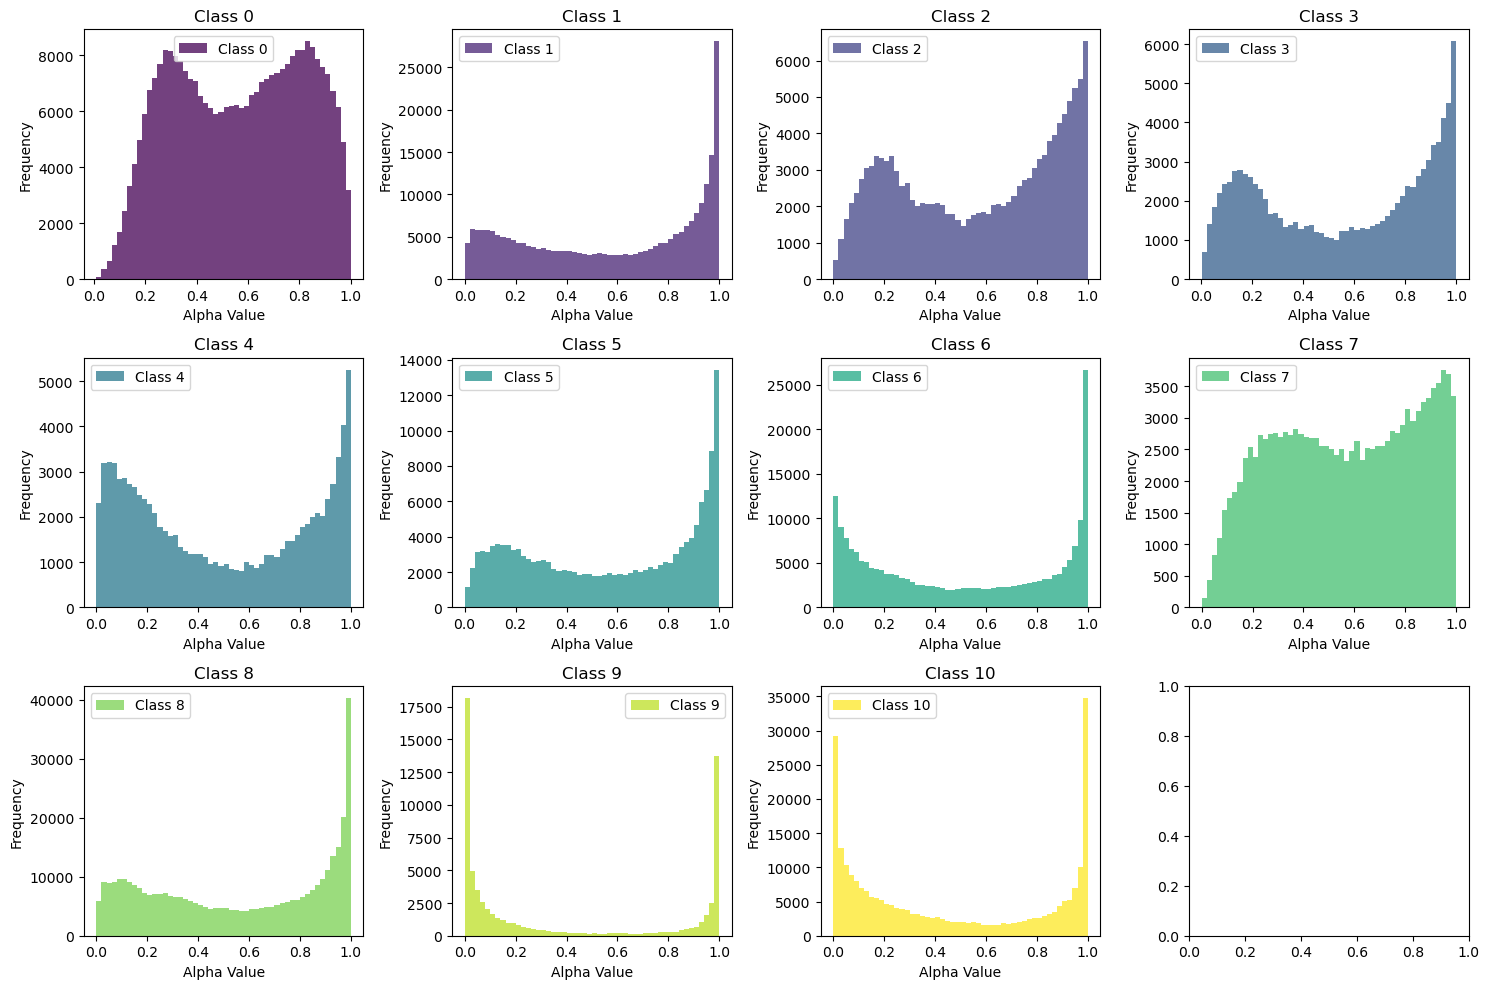

In [113]:
import matplotlib.pyplot as plt
import numpy as np


class_alpha_means = []
for cls in range(11):
    class_alpha = res2[res2['predicted'] == cls].alpha.apply(lambda x: x[:6])
    alpha_mean = np.stack(class_alpha.values).mean(axis=0)
    class_alpha_means.append(class_alpha)


# Define colors for the classes
colors = plt.cm.viridis(np.linspace(0, 1, 11))  # Using a colormap for distinct colors

# Create a figure with subplots for each class
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(15, 10))  # Adjust the size and number of subplots as needed
axes = axes.flatten()

# Plot alpha values for each class in a separate subplot
for cls in range(11):
    alpha_values = np.concatenate([a.flatten() for a in class_alpha_means[cls]])
    axes[cls].hist(alpha_values, bins=50, alpha=0.75, color=colors[cls], label=f'Class {cls}')
    axes[cls].set_xlabel('Alpha Value')
    axes[cls].set_ylabel('Frequency')
    axes[cls].set_title(f'Class {cls}')
    axes[cls].legend()

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()


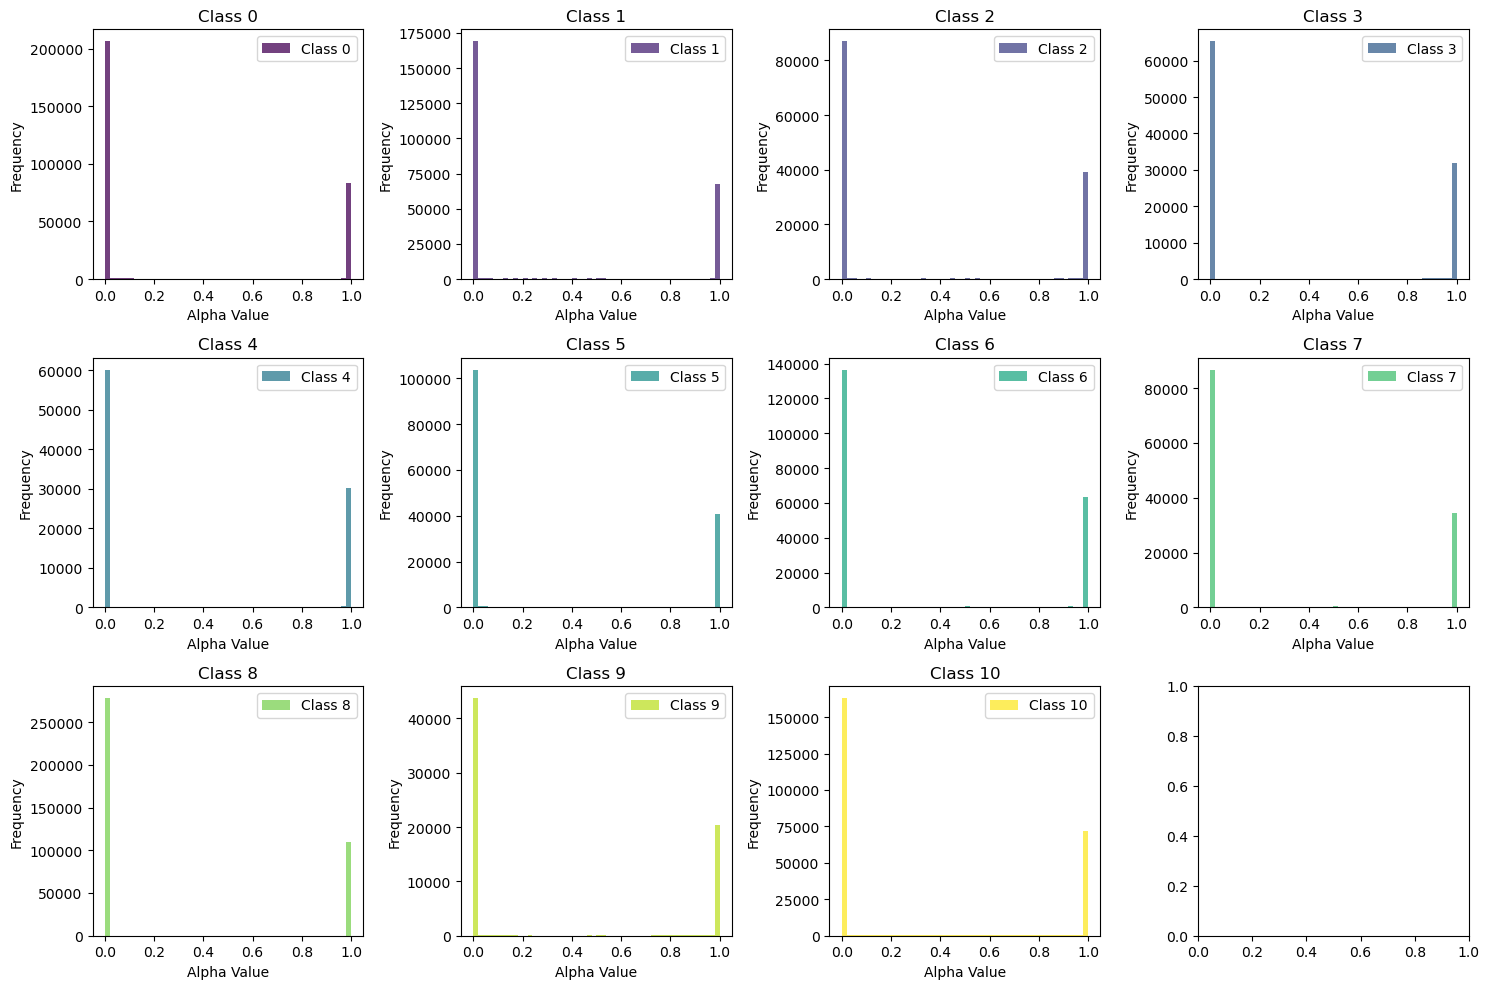

In [114]:
import matplotlib.pyplot as plt
import numpy as np

class_alpha_means = []
for cls in range(11):
    class_alpha = res2[res2['predicted'] == cls].alpha.apply(lambda x: x[6:])
    alpha_mean = np.stack(class_alpha.values).mean(axis=0)
    class_alpha_means.append(class_alpha)

# Define colors for the classes
colors = plt.cm.viridis(np.linspace(0, 1, 11))  # Using a colormap for distinct colors

# Create a figure with subplots for each class
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(15, 10))  # Adjust the size and number of subplots as needed
axes = axes.flatten()

# Plot alpha values for each class in a separate subplot
for cls in range(11):
    alpha_values = np.concatenate([a.flatten() for a in class_alpha_means[cls]])
    axes[cls].hist(alpha_values, bins=50, alpha=0.75, color=colors[cls], label=f'Class {cls}')
    axes[cls].set_xlabel('Alpha Value')
    axes[cls].set_ylabel('Frequency')
    axes[cls].set_title(f'Class {cls}')
    axes[cls].legend()

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()


In [ ]:
res.to_csv('f1-RTSB-lstm-alpha-acc94.csv', index=False)

In [ ]:
torch.save(model.state_dict(), (f'RTSB-lstm-alpha-acc94.pth'))

### Confusion matrix

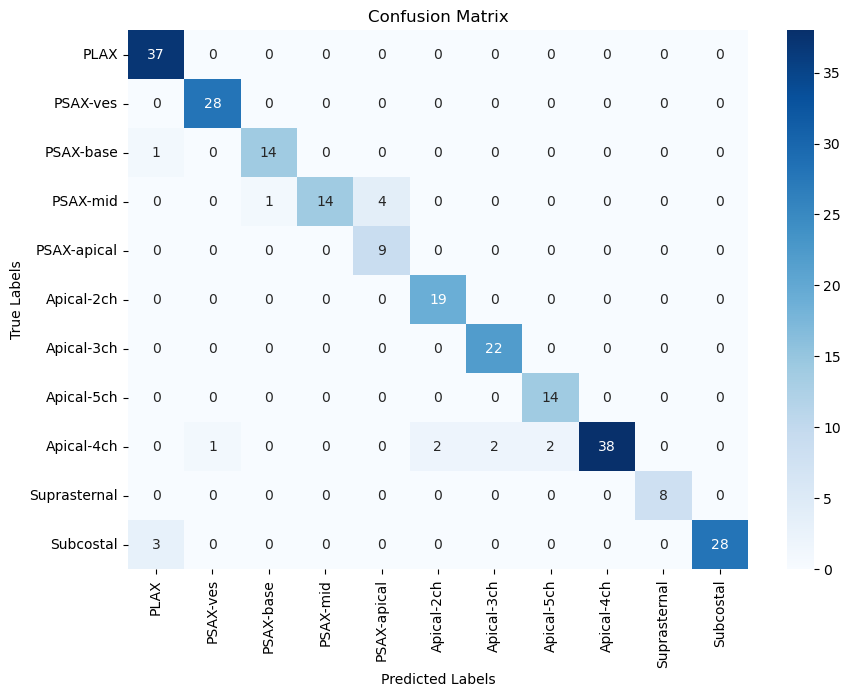

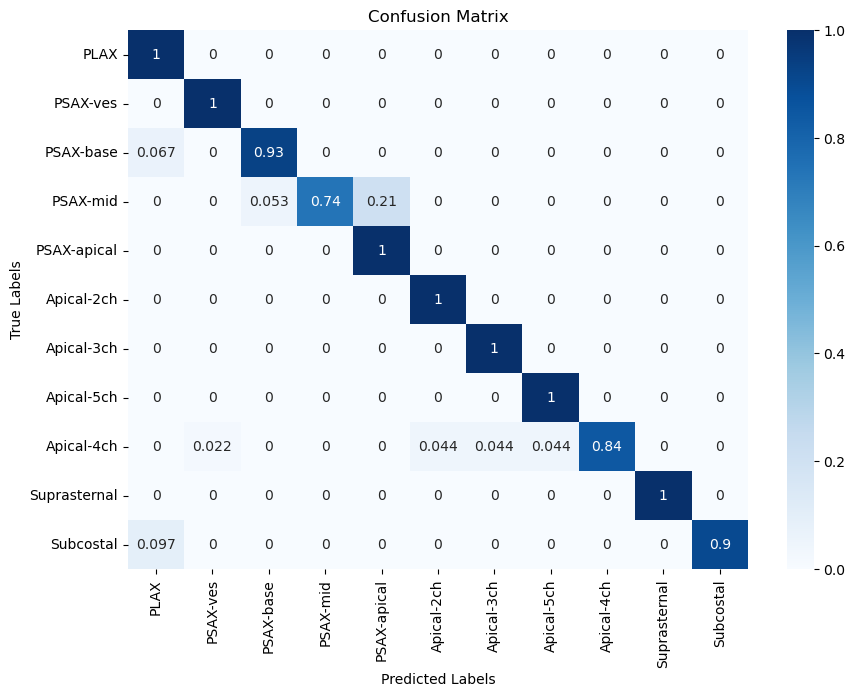

In [80]:
true_labels, pred_labels = res2['true_labels'], res2['predicted']
# valid_labels = {'PSAX-ves' : 1, 'PSAX-base' : 2, 'PSAX-mid' : 3, 'PSAX-apical' : 4 }
valid_labels = {'PLAX': 0, 'PSAX-ves' : 1, 'PSAX-base' : 2, 'PSAX-mid' : 3,
                              'PSAX-apical' : 4, 'Apical-2ch' : 5, 'Apical-3ch' : 6,
                              'Apical-5ch' : 7, 'Apical-4ch' : 8, 'Suprasternal' : 9, 'Subcostal' : 10
                            }

labels_name = valid_labels.keys()
        
cm = confusion_matrix(true_labels, pred_labels)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels_name, yticklabels=labels_name )
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

plt.figure(figsize=(10,7))
sns.heatmap(cm_normalized, annot=True, cmap='Blues', xticklabels=labels_name, yticklabels=labels_name )
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.savefig('confusion_matrix_finalModel_conv1dDilated_normalized.svg')
plt.show()

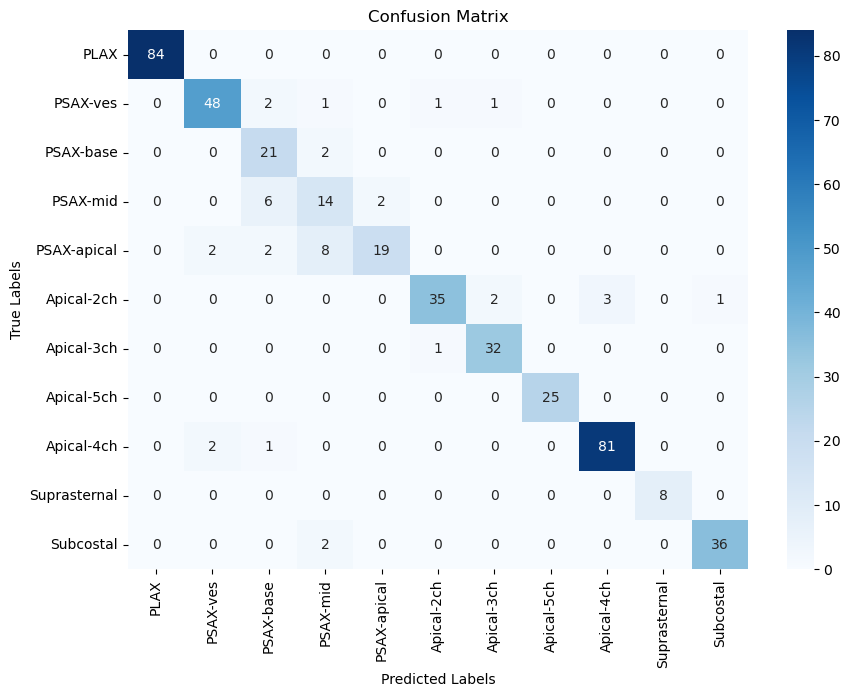

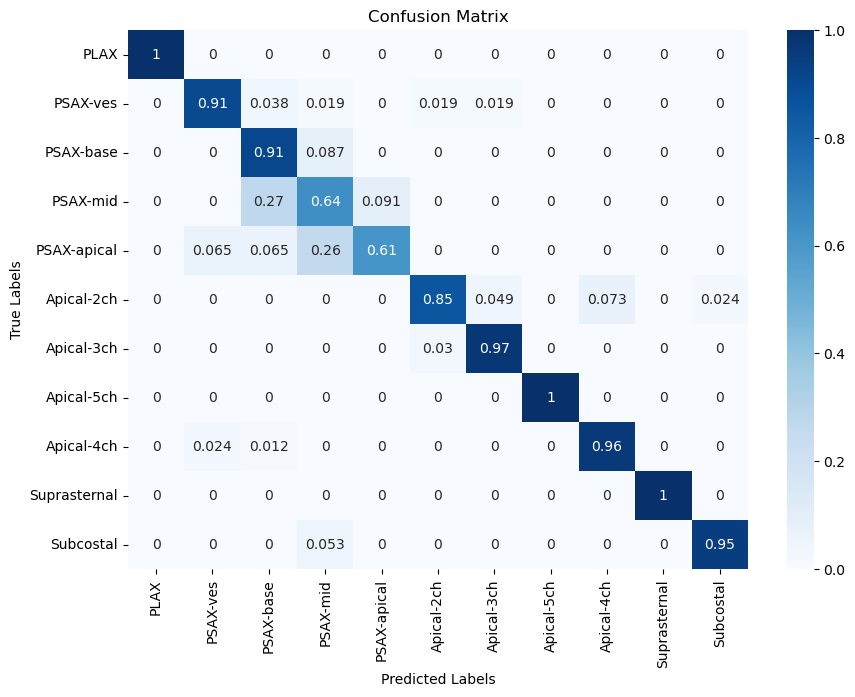

In [ ]:
true_labels, pred_labels = res['true_labels'], res['predicted']
# valid_labels = {'PSAX-ves' : 1, 'PSAX-base' : 2, 'PSAX-mid' : 3, 'PSAX-apical' : 4 }
valid_labels = {'PLAX': 0, 'PSAX-ves' : 1, 'PSAX-base' : 2, 'PSAX-mid' : 3,
                              'PSAX-apical' : 4, 'Apical-2ch' : 5, 'Apical-3ch' : 6,
                              'Apical-5ch' : 7, 'Apical-4ch' : 8, 'Suprasternal' : 9, 'Subcostal' : 10
                            }

labels_name = valid_labels.keys()
        
cm = confusion_matrix(true_labels, pred_labels)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels_name, yticklabels=labels_name )
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

plt.figure(figsize=(10,7))
sns.heatmap(cm_normalized, annot=True, cmap='Blues', xticklabels=labels_name, yticklabels=labels_name )
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
res2['true_labels'] = res2['true_labels'].apply(lambda x : 3 if x==4 else x)
res2['predicted'] = res2['predicted'].apply(lambda x : 3 if x==4 else x)
calculate_accuracy(res2['true_labels'], res2['predicted'])

0.9433198380566802

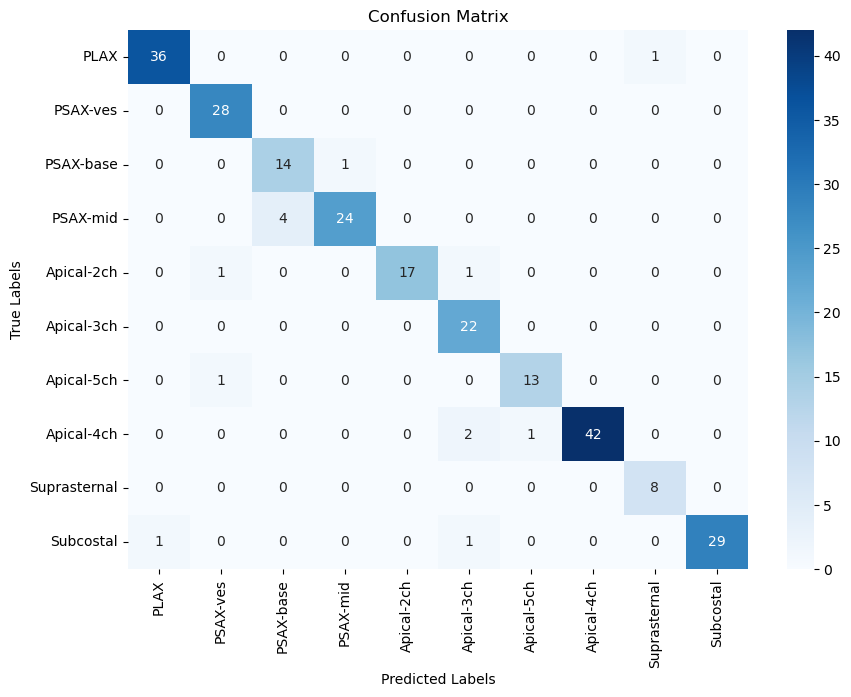

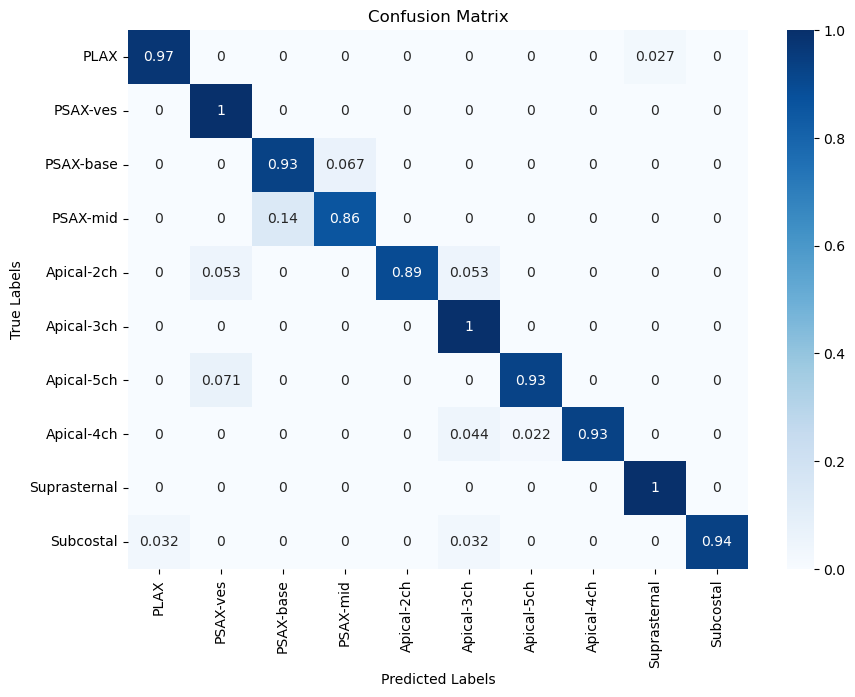

In [ ]:
true_labels, pred_labels = res2['true_labels'], res2['predicted']
# valid_labels = {'PSAX-ves' : 1, 'PSAX-base' : 2, 'PSAX-mid' : 3, 'PSAX-apical' : 4 }
valid_labels = {'PLAX': 0, 'PSAX-ves' : 1, 'PSAX-base' : 2, 'PSAX-mid' : 3,
                             'Apical-2ch' : 4, 'Apical-3ch' : 5,
                              'Apical-5ch' : 6, 'Apical-4ch' : 7, 'Suprasternal' : 8, 'Subcostal' : 9
                            }

labels_name = valid_labels.keys()
        
cm = confusion_matrix(true_labels, pred_labels)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels_name, yticklabels=labels_name )
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

plt.figure(figsize=(10,7))
sns.heatmap(cm_normalized, annot=True, cmap='Blues', xticklabels=labels_name, yticklabels=labels_name )
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

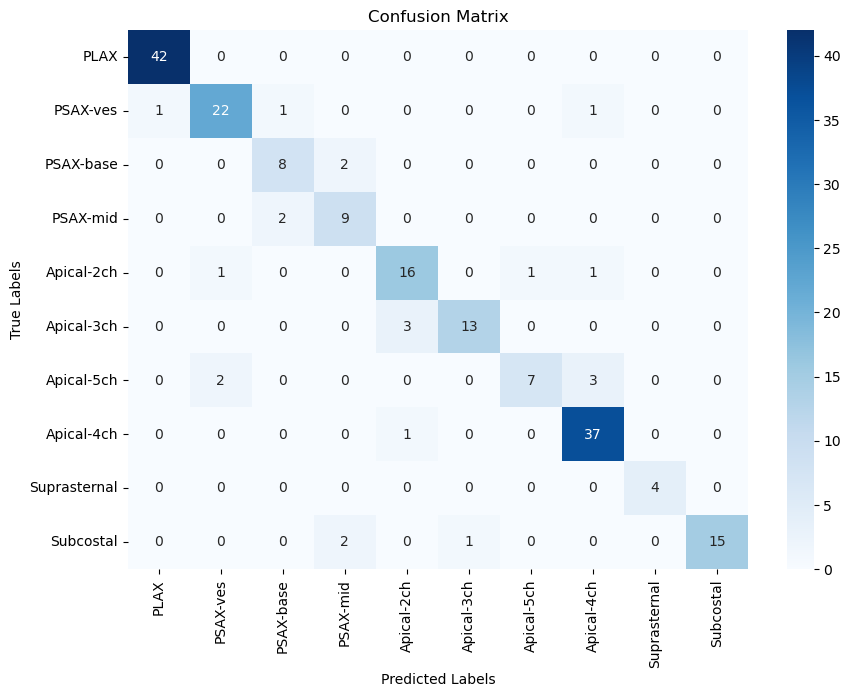

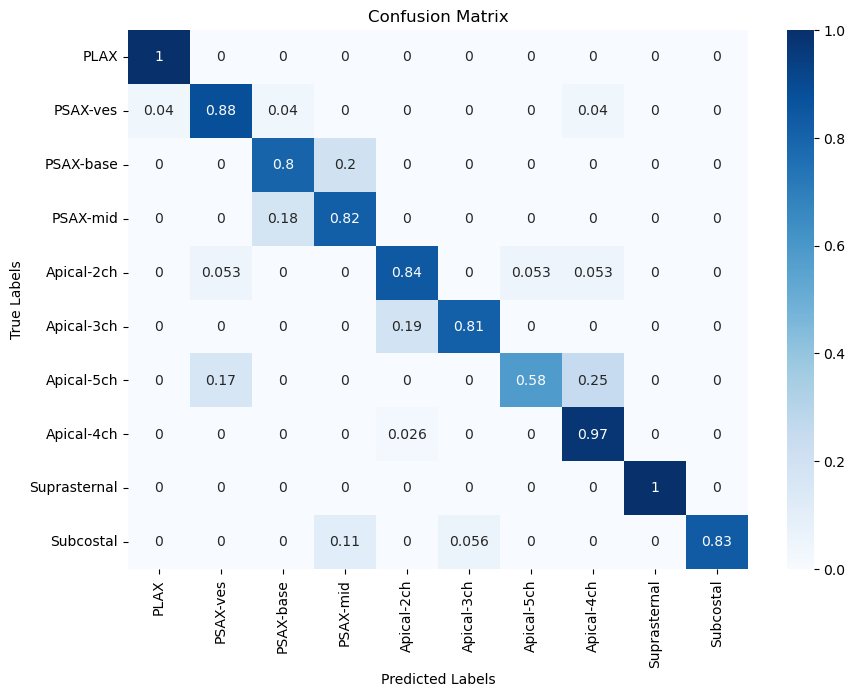

In [ ]:
true_labels, pred_labels = res['true_labels'], res['predicted']
# valid_labels = {'PSAX-ves' : 1, 'PSAX-base' : 2, 'PSAX-mid' : 3, 'PSAX-apical' : 4 }
valid_labels = {'PLAX': 0, 'PSAX-ves' : 1, 'PSAX-base' : 2, 'PSAX-mid' : 3,
                              'Apical-2ch' : 4, 'Apical-3ch' : 5,
                              'Apical-5ch' : 6, 'Apical-4ch' : 7, 'Suprasternal' : 8, 'Subcostal' : 9
                            }

labels_name = valid_labels.keys()
        
cm = confusion_matrix(true_labels, pred_labels)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels_name, yticklabels=labels_name )
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

plt.figure(figsize=(10,7))
sns.heatmap(cm_normalized, annot=True, cmap='Blues', xticklabels=labels_name, yticklabels=labels_name )
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

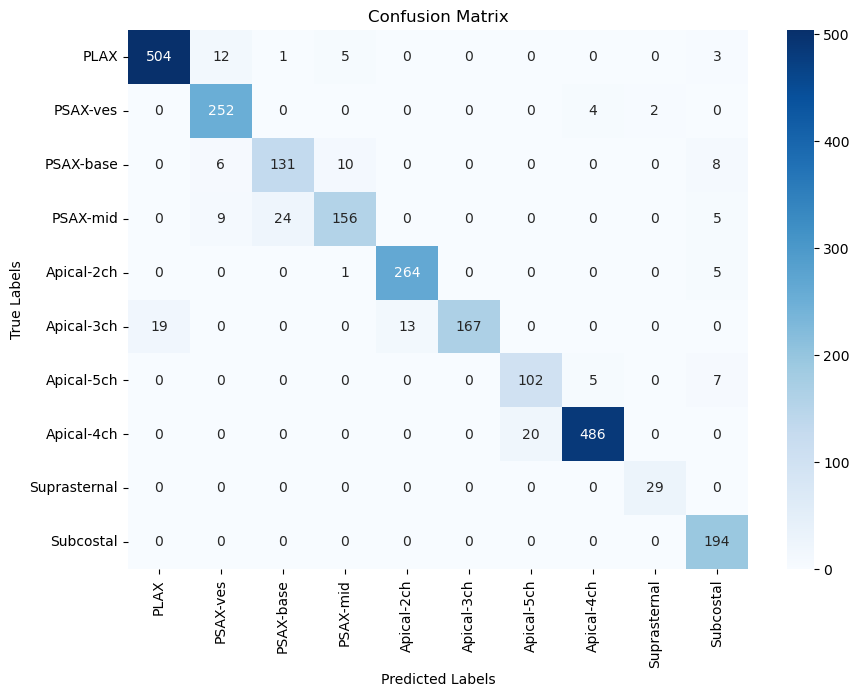

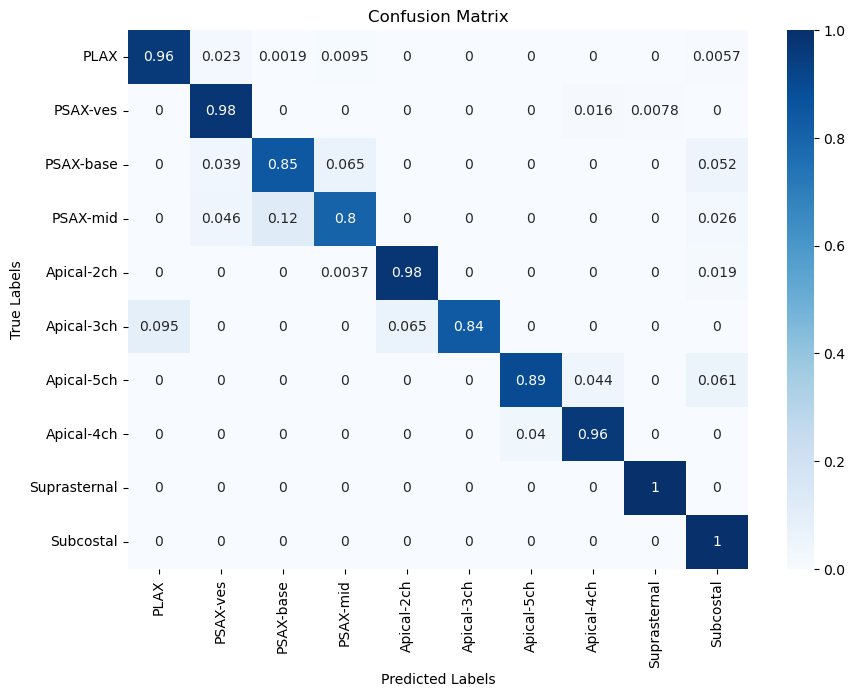

In [ ]:
true_labels, pred_labels = test['true_labels'], test['predicted']
# valid_labels = {'PSAX-ves' : 1, 'PSAX-base' : 2, 'PSAX-mid' : 3, 'PSAX-apical' : 4 }
valid_labels = {'PLAX': 0, 'PSAX-ves' : 1, 'PSAX-base' : 2, 'PSAX-mid' : 3,
                              'Apical-2ch' : 4, 'Apical-3ch' : 5,
                              'Apical-5ch' : 6, 'Apical-4ch' : 7, 'Suprasternal' : 8, 'Subcostal' : 9
                            }

labels_name = valid_labels.keys()
        
cm = confusion_matrix(true_labels, pred_labels)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels_name, yticklabels=labels_name )
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

plt.figure(figsize=(10,7))
sns.heatmap(cm_normalized, annot=True, cmap='Blues', xticklabels=labels_name, yticklabels=labels_name )
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

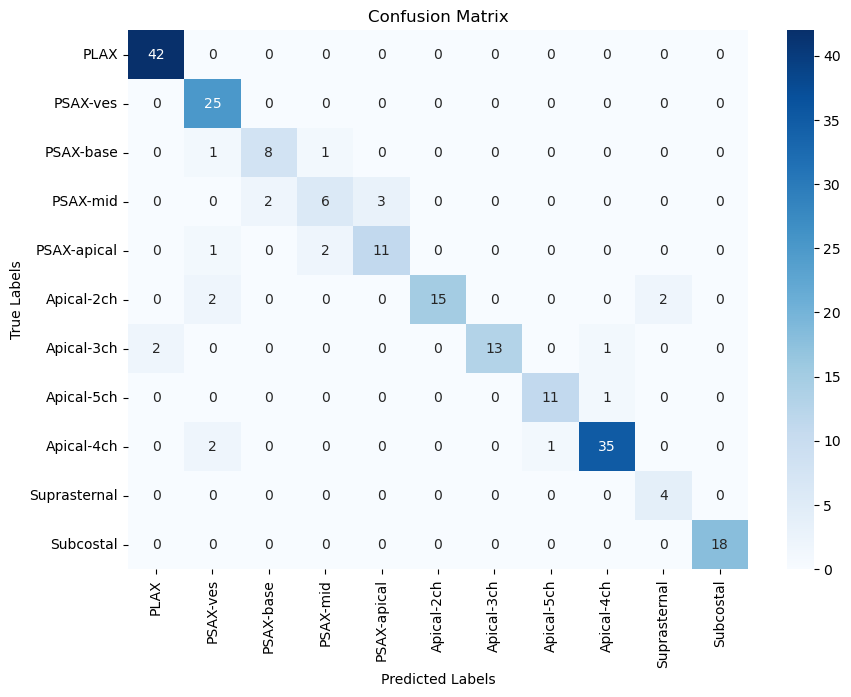

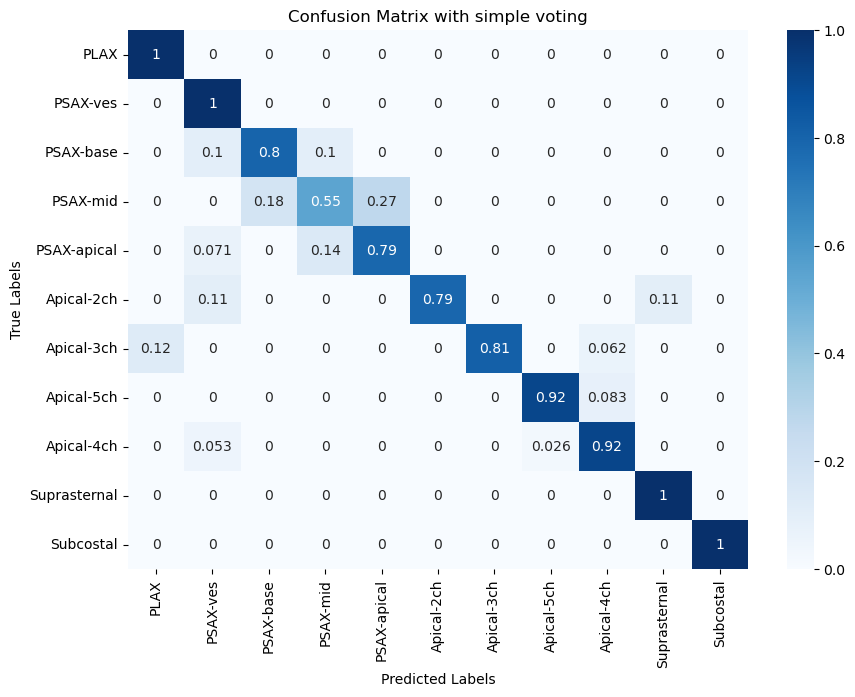

In [ ]:
true_labels, pred_labels = res['true_labels'], res['predicted']
# valid_labels = {'PSAX-ves' : 1, 'PSAX-base' : 2, 'PSAX-mid' : 3, 'PSAX-apical' : 4 }
valid_labels = {'PLAX':0, 'PSAX-ves' : 1, 'PSAX-base' : 2, 'PSAX-mid' : 3,
                              'PSAX-apical' : 4, 'Apical-2ch' : 5, 'Apical-3ch' : 6,
                              'Apical-5ch' : 7, 'Apical-4ch' : 8, 'Suprasternal' : 9, 'Subcostal' : 10
               }

labels_name = valid_labels.keys()
        
cm = confusion_matrix(true_labels, pred_labels)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels_name, yticklabels=labels_name )
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

plt.figure(figsize=(10,7))
sns.heatmap(cm_normalized, annot=True, cmap='Blues', xticklabels=labels_name, yticklabels=labels_name )
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix with simple voting')
plt.show()

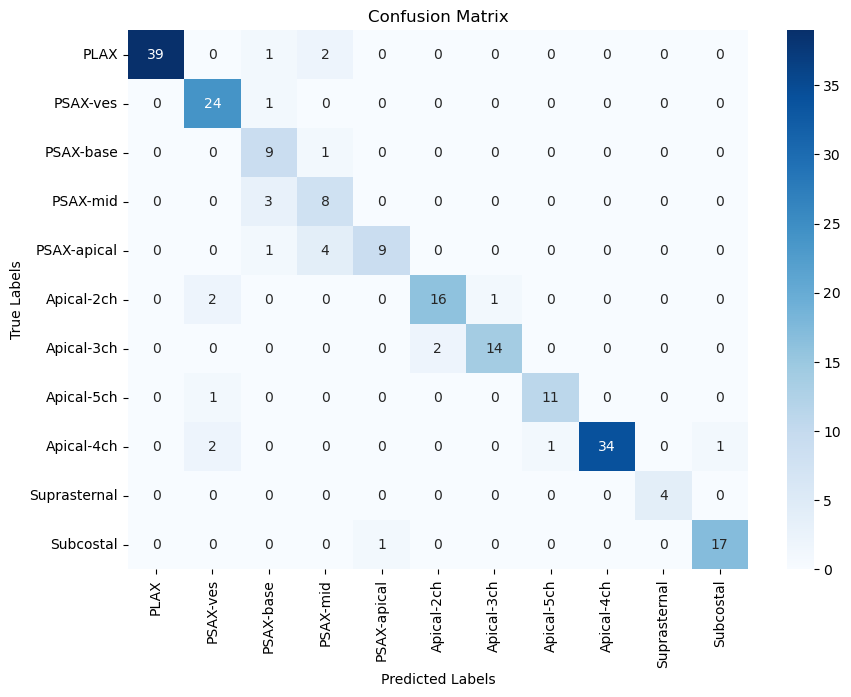

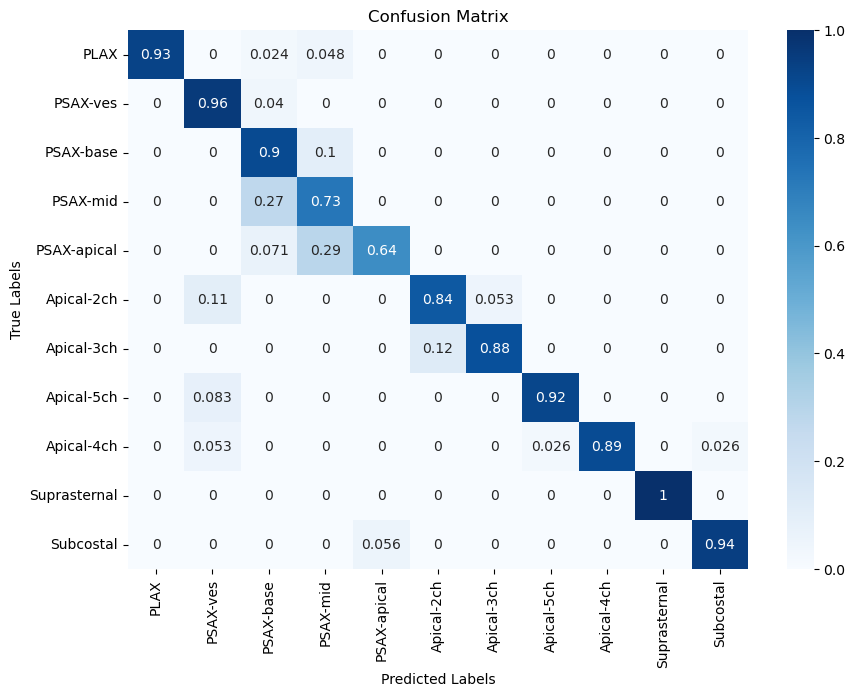

In [ ]:
true_labels, pred_labels = aggregated_results['true_labels'], aggregated_results['final_prediction']

valid_labels = {'PLAX': 0, 'PSAX-ves' : 1, 'PSAX-base' : 2, 'PSAX-mid' : 3,
                              'PSAX-apical' : 4, 'Apical-2ch' : 5, 'Apical-3ch' : 6,
                              'Apical-5ch' : 7, 'Apical-4ch' : 8, 'Suprasternal' : 9, 'Subcostal' : 10
               }

labels_name = valid_labels.keys()
        
cm = confusion_matrix(true_labels, pred_labels)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels_name, yticklabels=labels_name )
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

plt.figure(figsize=(10,7))
sns.heatmap(cm_normalized, annot=True, cmap='Blues', xticklabels=labels_name, yticklabels=labels_name )
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

/home/student/shokoofa/anaconda3/lib/python3.9/site-packages/torch/nn/modules/rnn.py:774: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:968.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


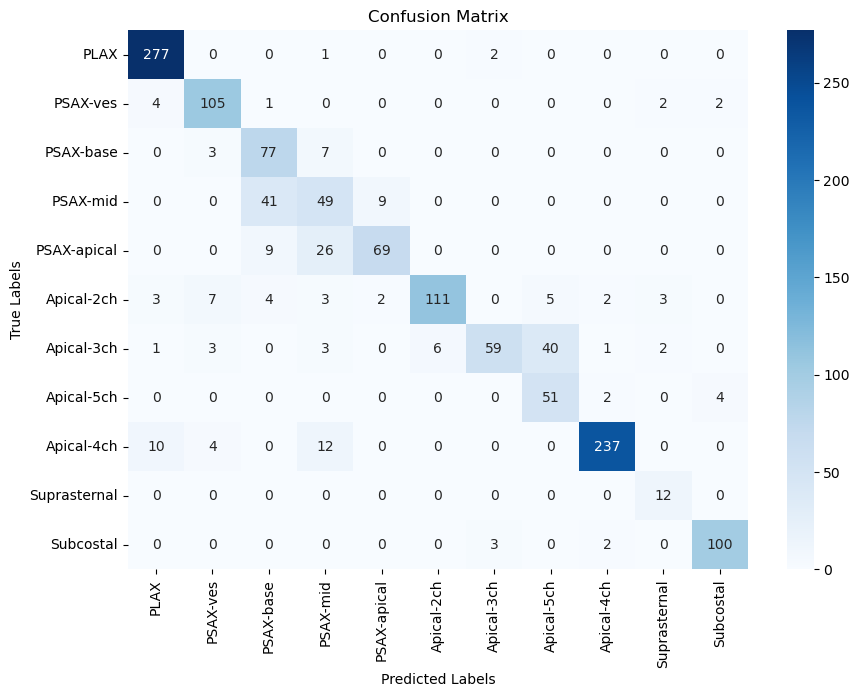

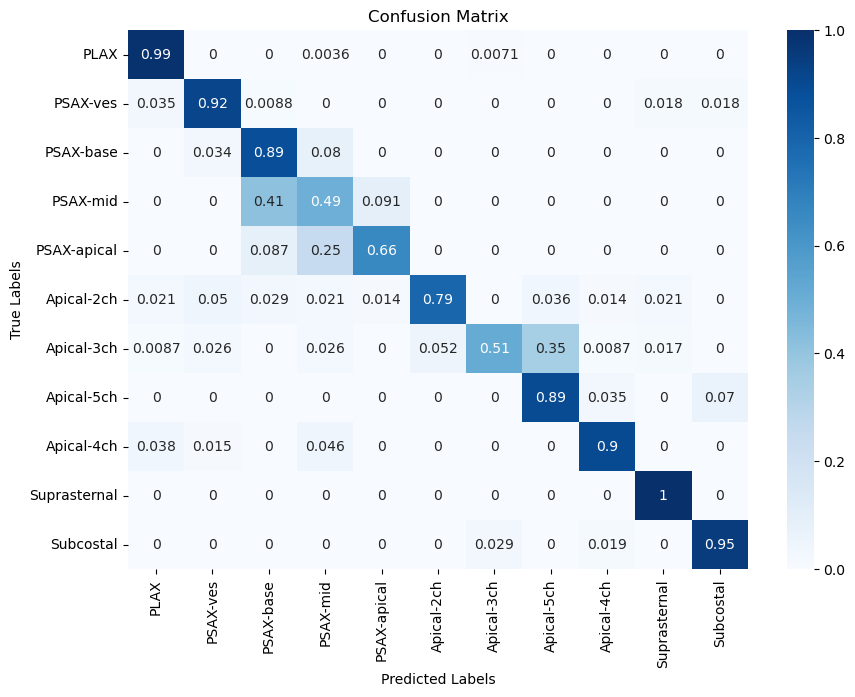

In [ ]:
true_labels, pred_labels = [], []

valid_labels = {'PLAX': 0, 'PSAX-ves' : 1, 'PSAX-base' : 2, 'PSAX-mid' : 3,
                              'PSAX-apical' : 4, 'Apical-2ch' : 5, 'Apical-3ch' : 6,
                              'Apical-5ch' : 7, 'Apical-4ch' : 8, 'Suprasternal' : 9, 'Subcostal' : 10
               }

labels_name = valid_labels.keys()
model.eval()
for i, (images, labels) in enumerate(test_loader):
    images = images.to(device)
    labels = labels.to(device)
    labels = labels.squeeze(1)
    
    with torch.no_grad():
        outputs = model(images)
        _, predictions = outputs.max(1)
        true_labels.extend(labels.cpu().numpy())
        pred_labels.extend(predictions.cpu().numpy())
        
cm = confusion_matrix(true_labels, pred_labels)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels_name, yticklabels=labels_name )
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

plt.figure(figsize=(10,7))
sns.heatmap(cm_normalized, annot=True, cmap='Blues', xticklabels=labels_name, yticklabels=labels_name )
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()